# Importar librerias para trabajar

In [1]:
# para trabajar los df
import pandas as pd
import numpy as np

# para las redes neuronales mlp
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# para los graficos
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams


In [2]:
import warnings

# Suprimir los warnings específicos de RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Preparando Datasets

## Dataset de Cultivos

In [3]:
# leer un archivo csv
df_cultivos = pd.read_csv('datasets/estimaciones-agricolas-2023-10.csv', encoding='iso-8859-1', low_memory=False)

In [4]:
# renombrar la columna mal escrita
df_cultivos = df_cultivos.rename(columns={'produccion ': 'produccion'})

In [5]:
df_cultivos.shape

(153889, 12)

In [6]:
# ver las columnas que trae el dataset
df_cultivos.columns

Index(['id_provincia', 'provincia', 'id_departamento', 'departamento',
       'id_cultivo', 'cultivo', 'id_campaña', 'campaña', 'sup_sembrada',
       'sup_cosechada', 'produccion', 'rendimiento'],
      dtype='object')

In [7]:
# separar inicio y fin de campaña
df_cultivos['año_inicio'] = df_cultivos['campaña'].apply(lambda x: x.split('/')[0])
df_cultivos['año_fin'] = df_cultivos['campaña'].apply(lambda x: x.split('/')[1])

In [8]:
# quedarnos solo con las columnas que nos interesan
columnas_deseadas = ['provincia', 'cultivo', 'año_inicio', 'año_fin', 'sup_sembrada', 'sup_cosechada', 'produccion', 'rendimiento']
df_cultivos = df_cultivos[columnas_deseadas]

In [9]:
df_cultivos.head()

provincia cultivo año_inicio año_fin  sup_sembrada sup_cosechada  \
0  Buenos Aires     Ajo       1969    1970             3             3   
1  Buenos Aires     Ajo       1969    1970            15            15   
2  Buenos Aires     Ajo       1969    1970             5             5   
3  Buenos Aires     Ajo       1969    1970             2             2   
4  Buenos Aires     Ajo       1969    1970             6             6   

  produccion rendimiento  
0         10        3333  
1         82        5467  
2          7        1400  
3          8        4000  
4         15        2500

In [10]:
inicio = df_cultivos['año_inicio'].min()
fin = df_cultivos['año_fin'].max()

print(f'Los datos van desde el año {inicio} hasta {fin}')

Los datos van desde el año 1969 hasta 2023


In [11]:
# Convertir las columnas a tipo numérico, si el valor no es convertible colocar NaN
df_cultivos['año_inicio'] = pd.to_numeric(df_cultivos['año_inicio'], errors='coerce')
df_cultivos['año_fin'] = pd.to_numeric(df_cultivos['año_fin'], errors='coerce')
df_cultivos['sup_cosechada'] = pd.to_numeric(df_cultivos['sup_cosechada'], errors='coerce')
df_cultivos['produccion'] = pd.to_numeric(df_cultivos['produccion'], errors='coerce')
df_cultivos['rendimiento'] = pd.to_numeric(df_cultivos['rendimiento'], errors='coerce')

In [12]:
# Reemplazar los valores igual a 0 con NaN
df_cultivos['sup_cosechada'] = df_cultivos['sup_cosechada'].replace(0, pd.NA)
df_cultivos['produccion'] = df_cultivos['produccion'].replace(0, pd.NA)
df_cultivos['rendimiento'] = df_cultivos['rendimiento'].replace(0, pd.NA)

In [13]:
# eliminar las filas donde sup_cosechada > sup_sembrada
df_cultivos = df_cultivos[df_cultivos['sup_cosechada'] <= df_cultivos['sup_sembrada']]

In [14]:
# mostrar los nulos por columna
df_cultivos.isnull().sum()

provincia         0
cultivo           0
año_inicio        0
año_fin           0
sup_sembrada      0
sup_cosechada     0
produccion       34
rendimiento      34
dtype: int64

In [15]:
# mostrar el tipo de dato de cada columna
df_cultivos.dtypes

provincia        object
cultivo          object
año_inicio        int64
año_fin           int64
sup_sembrada      int64
sup_cosechada    object
produccion       object
rendimiento      object
dtype: object

In [16]:
# Calcular el promedio general para cada columna
promedio_sup_cosechada = df_cultivos['sup_cosechada'].mean()
promedio_produccion = df_cultivos['produccion'].mean()
promedio_rendimiento = df_cultivos['rendimiento'].mean()

# Recorrer cada fila del DataFrame
for index, row in df_cultivos.iterrows():
    # Reemplazar los valores nulos con los promedios calculados
    if pd.isnull(row['sup_cosechada']):
        df_cultivos.at[index, 'sup_cosechada'] = promedio_sup_cosechada
        
    if pd.isnull(row['produccion']):
        df_cultivos.at[index, 'produccion'] = promedio_produccion
        
    if pd.isnull(row['rendimiento']):
        df_cultivos.at[index, 'rendimiento'] = promedio_rendimiento

In [17]:
# terminamos de limpiar los valores nulos
df_cultivos.isnull().sum()

provincia        0
cultivo          0
año_inicio       0
año_fin          0
sup_sembrada     0
sup_cosechada    0
produccion       0
rendimiento      0
dtype: int64

In [18]:
# vamos a trabajar con una granularidad por provincias
df_cultivos = df_cultivos.groupby(['año_inicio', 'año_fin', 'provincia', 'cultivo']).agg({
    'sup_sembrada': 'sum',
    'sup_cosechada': 'sum',
    'produccion': 'sum',
    'rendimiento': lambda x: int(round(x.mean()))
}).reset_index()

In [19]:
# ver la cantidad de tuplas que finalmente quedaron en nuestro conjunto de datos
# tambien la cantidad de columnas
df_cultivos.shape

(11269, 8)

In [20]:
# forzamos el tipo de dato a entero
df_cultivos['sup_cosechada'] = df_cultivos['sup_cosechada'].astype(int)
df_cultivos['produccion'] = df_cultivos['produccion'].astype(int)

In [21]:
df_cultivos.dtypes

año_inicio        int64
año_fin           int64
provincia        object
cultivo          object
sup_sembrada      int64
sup_cosechada     int64
produccion        int64
rendimiento       int64
dtype: object

In [22]:
df_cultivos.head()

año_inicio  año_fin     provincia           cultivo  sup_sembrada  \
0        1969     1970  Buenos Aires               Ajo          5290   
1        1969     1970  Buenos Aires           Alpiste        119200   
2        1969     1970  Buenos Aires             Avena        788440   
3        1969     1970  Buenos Aires  Cebada cervecera        322480   
4        1969     1970  Buenos Aires  Cebada forrajera        141960   

   sup_cosechada  produccion  rendimiento  
0           5290       23458         3719  
1         112100      104000          799  
2         299900      404700         1228  
3         294200      412800         1445  
4          49600       60500         1307

In [23]:
# tipos de cultivos en el dataset
df_cultivos['cultivo'].unique()

array(['Ajo', 'Alpiste', 'Avena', 'Cebada cervecera', 'Cebada forrajera',
       'Cebolla total', 'Centeno', 'Girasol', 'Lino', 'Maíz', 'Mijo',
       'Papa total', 'Poroto seco', 'Soja total', 'Sorgo', 'Trigo total',
       'Algodón', 'Arroz', 'Caña de azúcar', 'Cártamo', 'Maní', 'Tung',
       'Té', 'Yerba mate', 'Limón', 'Mandarina', 'Naranja', 'Pomelo',
       'Trigo candeal', 'Banana', 'Colza', 'Jojoba', 'Soja 1ra',
       'Soja 2da', 'Cebada total', 'Poroto total', 'Arveja', 'Garbanzo',
       'Lenteja', 'Poroto otros', 'Poroto negro', 'Poroto alubia'],
      dtype=object)

## Dataset de Clima

In [24]:
df_clima = pd.read_csv('datasets/GlobalLandTemperaturesByCountry.csv') 

In [25]:
df_clima.shape

(577462, 4)

In [26]:
df_clima.head()

dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland

In [27]:
# filtrar por pais argentina
df_clima = df_clima[df_clima['Country'] == 'Argentina']

In [28]:
df_clima.shape

(1901, 4)

In [29]:
# Convertir la columna dt a formato datetime
df_clima['dt'] = pd.to_datetime(df_clima['dt'])

# Agregar una columna Year extraida de dt
df_clima['Year'] = df_clima['dt'].dt.year

# Agrupar por Year y calcular el promedio de AverageTemperature
df_clima = df_clima.groupby('Year')['AverageTemperature'].mean().reset_index()

In [30]:
df_clima.head()

Year  AverageTemperature
0  1855           11.729250
1  1856           13.998750
2  1857           14.221083
3  1858           14.015667
4  1859           14.414583

In [31]:
df_clima.dtypes

Year                    int32
AverageTemperature    float64
dtype: object

In [32]:
min_year = df_clima['Year'].min()
max_year = df_clima['Year'].max()

print('El año minimo es ', min_year)
print('El año maximo es ', max_year)

El año minimo es  1855
El año maximo es  2013


## Dataset suelos

In [33]:
df_suelos = pd.read_csv('datasets/tipos_suelos.csv') 

print(df_suelos)

              provincia    tipo_suelo
0          Buenos Aires     Molisoles
1          Buenos Aires    Vertisoles
2               Cordoba     Molisoles
3               Cordoba     Entisoles
4              Santa Fe     Molisoles
5              Santa Fe    Vertisoles
6               Mendoza    Aridisoles
7              San Juan    Aridisoles
8              San Luis    Aridisoles
9              San Luis     Entisoles
10             La Pampa     Molisoles
11           Entre Rios     Molisoles
12           Entre Rios    Vertisoles
13             Misiones     Ultisoles
14           Corrientes     Molisoles
15           Corrientes     Ultisoles
16              Formosa     Molisoles
17              Formosa    Vertisoles
18                Chaco     Molisoles
19                Chaco    Vertisoles
20  Santiago del Estero     Entisoles
21  Santiago del Estero    Aridisoles
22              Tucuman     Molisoles
23              Tucuman     Entisoles
24                Salta     Entisoles
25          

## Dataset final

In [34]:
# unir el df cultivos con df clima
df = pd.merge(df_cultivos, df_clima, left_on='año_inicio', right_on='Year', how='inner')
df.drop('Year', axis=1, inplace=True)
df = df.rename(columns={'AverageTemperature': 'temperatura'})

In [35]:
# unir el df suelos
# obtener los distintos tipos de suelos en argentina
tipos_suelos = df_suelos['tipo_suelo'].unique()

for tipo in tipos_suelos:
    # Crear una columna con nombre tipo_suelo y marcar con 1 si la provincia tiene ese tipo de suelo
    # df_suelos['tipo_suelo'] == tipo lo que hace es filtrar por el tipo de suelo de la iteracion
    # agregar ['provincia'] lo que hace es proyectar solo la columna provincia
    # df['provincia'].isin(...) verifica si cada valor en la columna provincia del df se encuentra en la lista obtenida 
    # esto devuelve una serie booleana por cada fila del df 
    # luego lo fuerza a entero
    # y lo asigna a la columna del tipo de suelo de la iteracion
    df[tipo.lower()] = df['provincia'].isin(df_suelos[df_suelos['tipo_suelo'] == tipo]['provincia']).astype(int)


In [36]:
df.isnull().sum()

año_inicio       0
año_fin          0
provincia        0
cultivo          0
sup_sembrada     0
sup_cosechada    0
produccion       0
rendimiento      0
temperatura      0
molisoles        0
vertisoles       0
entisoles        0
aridisoles       0
ultisoles        0
inceptisoles     0
histosoles       0
dtype: int64

In [37]:
df.head()

año_inicio  año_fin     provincia           cultivo  sup_sembrada  \
0        1969     1970  Buenos Aires               Ajo          5290   
1        1969     1970  Buenos Aires           Alpiste        119200   
2        1969     1970  Buenos Aires             Avena        788440   
3        1969     1970  Buenos Aires  Cebada cervecera        322480   
4        1969     1970  Buenos Aires  Cebada forrajera        141960   

   sup_cosechada  produccion  rendimiento  temperatura  molisoles  vertisoles  \
0           5290       23458         3719    15.262833          1           1   
1         112100      104000          799    15.262833          1           1   
2         299900      404700         1228    15.262833          1           1   
3         294200      412800         1445    15.262833          1           1   
4          49600       60500         1307    15.262833          1           1   

   entisoles  aridisoles  ultisoles  inceptisoles  histosoles  
0          0           0          0             0           0  
1          0           0          0             0           0  
2          0           0          0             0           0  
3          0           0          0             0           0  
4          0           0          0             0           0

In [38]:
df.dtypes

año_inicio         int64
año_fin            int64
provincia         object
cultivo           object
sup_sembrada       int64
sup_cosechada      int64
produccion         int64
rendimiento        int64
temperatura      float64
molisoles          int64
vertisoles         int64
entisoles          int64
aridisoles         int64
ultisoles          int64
inceptisoles       int64
histosoles         int64
dtype: object

In [39]:
df.shape

(9710, 16)

# Graficos

## Tendencias centrales

In [40]:
df.describe().round().astype(int)

año_inicio  año_fin  sup_sembrada  sup_cosechada  produccion  \
count        9710     9710          9710           9710        9710   
mean         1988     1989        139732         121874      361345   
std            12       12        470834         453386     1350554   
min          1969     1970             1              1           3   
25%          1978     1979           700            545        1600   
50%          1986     1987          6200           4600       13900   
75%          1998     1999         60000          42450      113000   
max          2013     2014       6734155        6625050    17812968   

       rendimiento  temperatura  molisoles  vertisoles  entisoles  aridisoles  \
count         9710         9710       9710        9710       9710        9710   
mean          5289           15          1           0          0           0   
std           8521            0          0           0          0           0   
min              8           14          0           0          0           0   
25%           1167           15          0           0          0           0   
50%           2050           15          1           0          0           0   
75%           5410           15          1           1          1           1   
max         108568           16          1           1          1           1   

       ultisoles  inceptisoles  histosoles  
count       9710          9710        9710  
mean           0             0           0  
std            0             0           0  
min            0             0           0  
25%            0             0           0  
50%            0             0           0  
75%            0             0           0  
max            1             1           1

## Histogramas

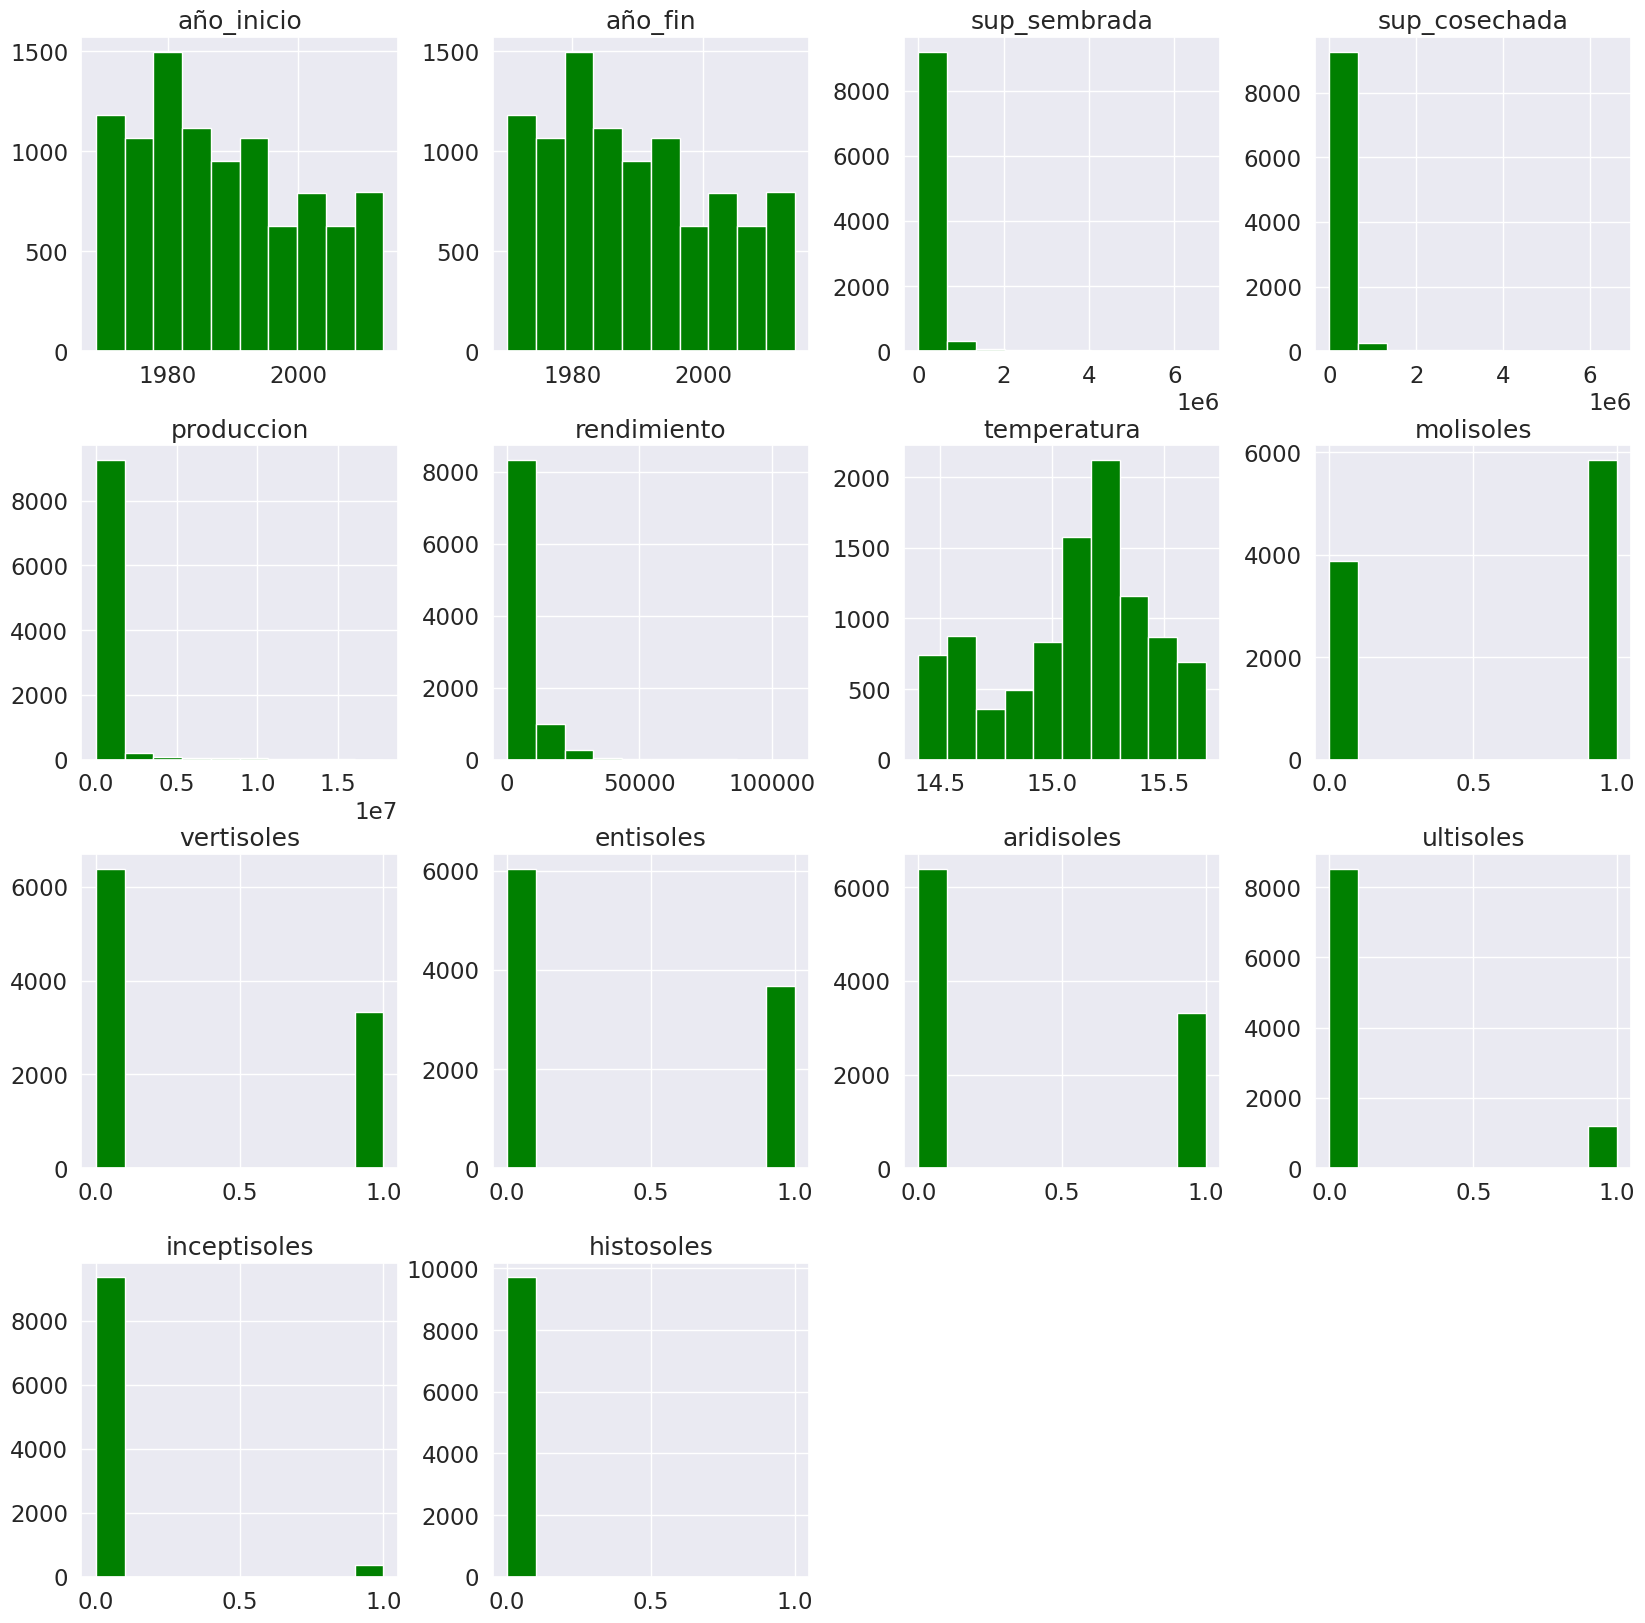

In [41]:
sns.set(style = "darkgrid", font_scale = 1.5, rc = { 'figure.figsize': (20,20)})
ax = df.hist(bins=10, color="green")

## Balanceo de clase cultivo

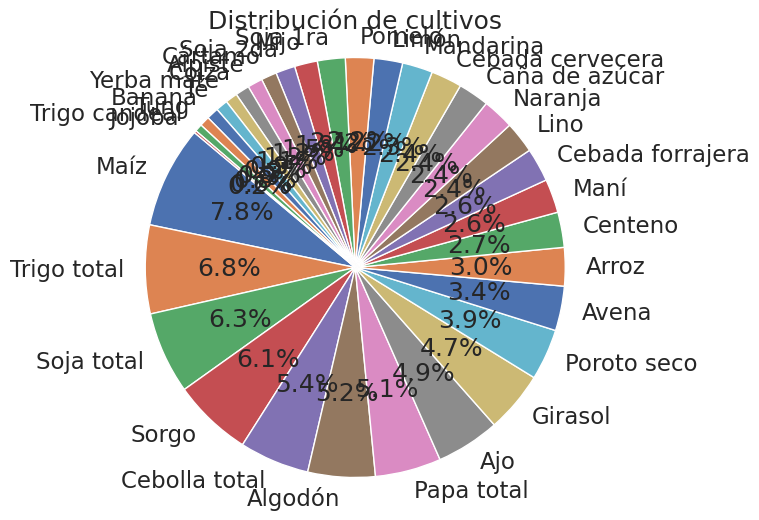

In [42]:
plt.figure(figsize=(8, 6))
df['cultivo'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribución de cultivos')
plt.ylabel('')
plt.axis('equal')  # Para asegurar que el gráfico sea un círculo
plt.show()

## Balanceo de clase provincia

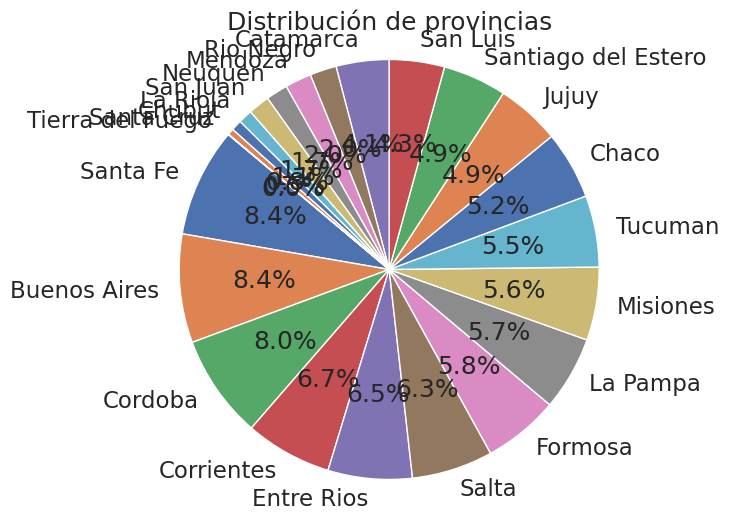

In [43]:
plt.figure(figsize=(8, 6))
df['provincia'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribución de provincias')
plt.ylabel('')
plt.axis('equal')  # Para asegurar que el gráfico sea un círculo
plt.show()

## Balanceo de la clase nivel rendimiento

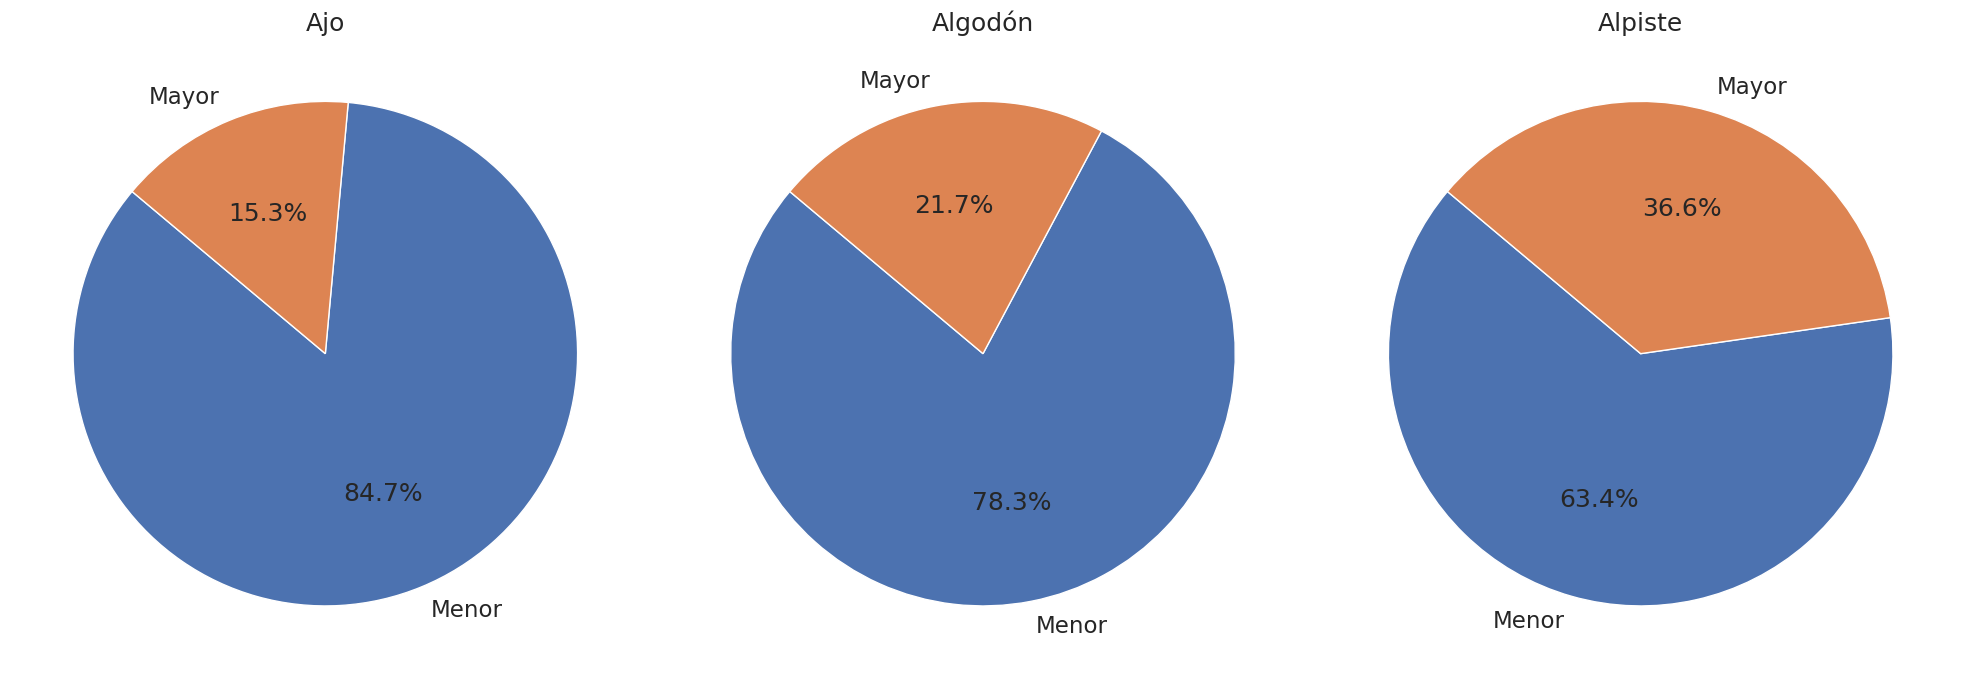

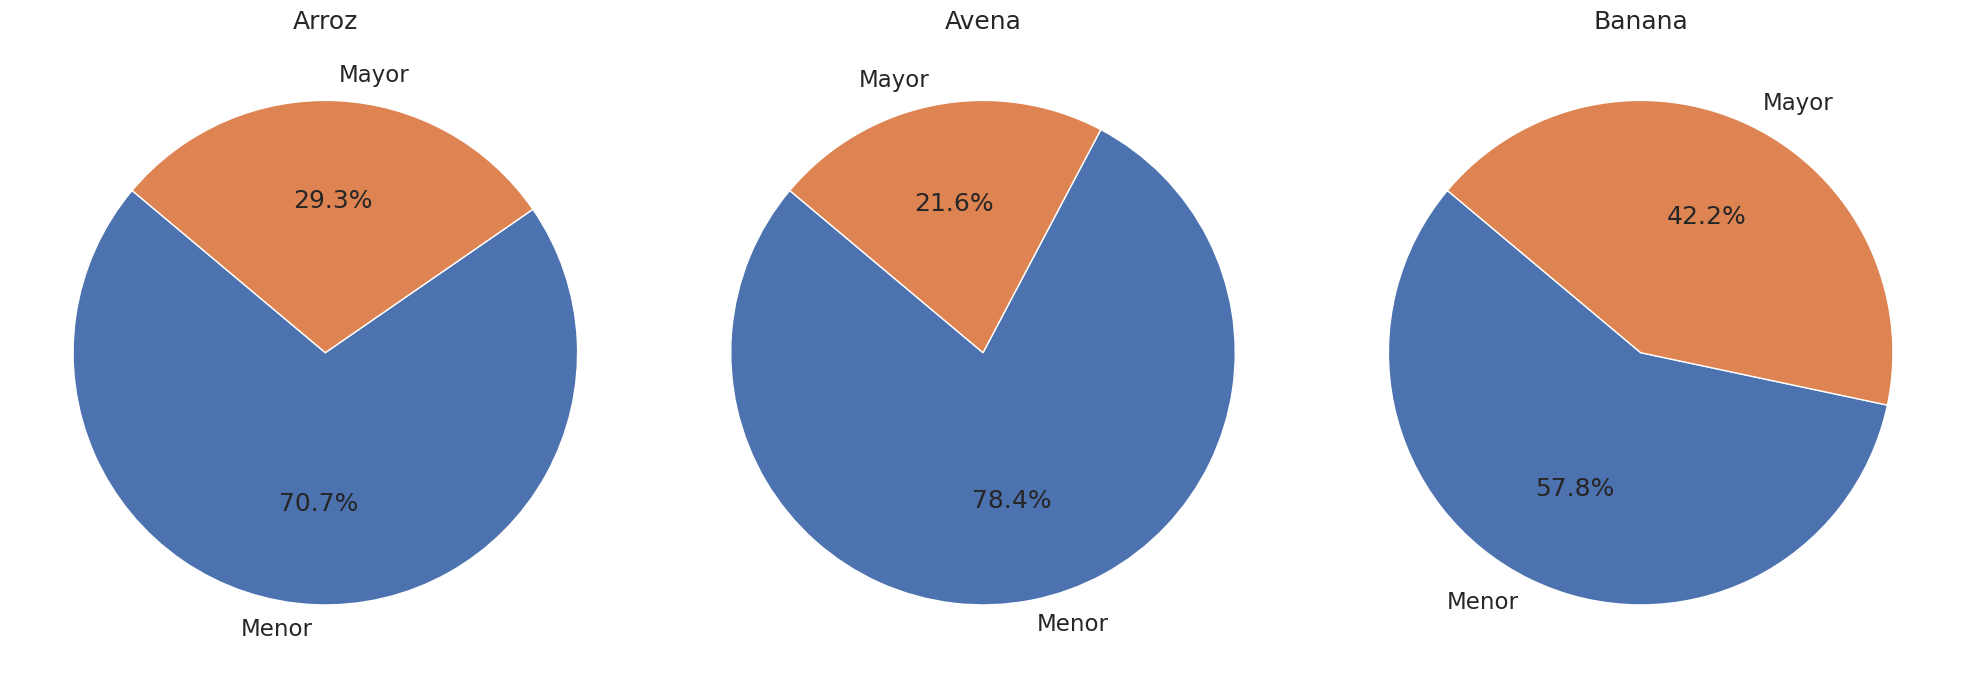

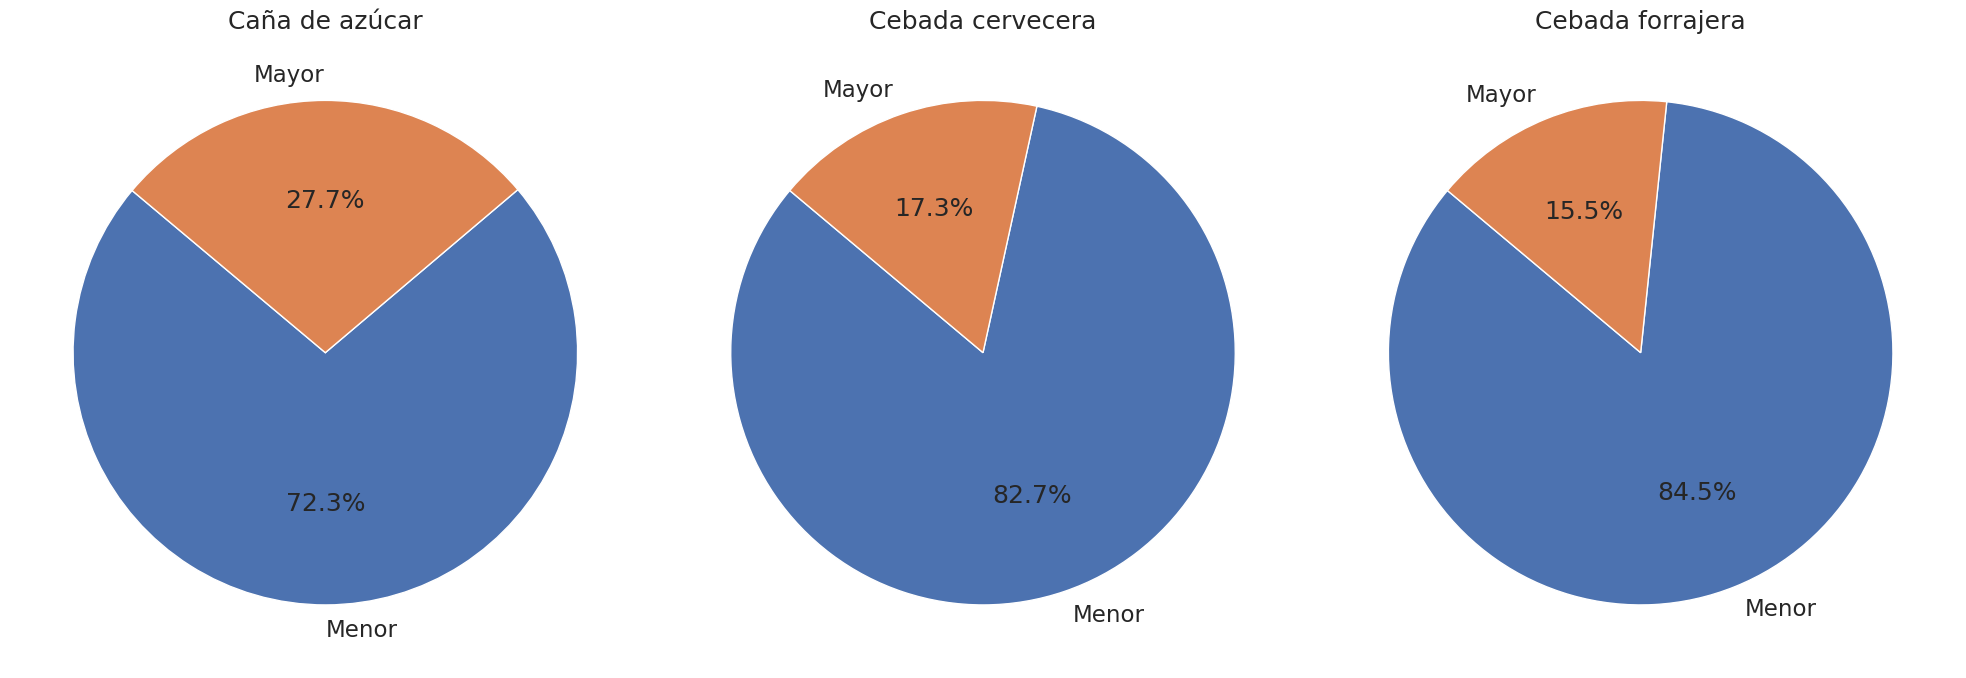

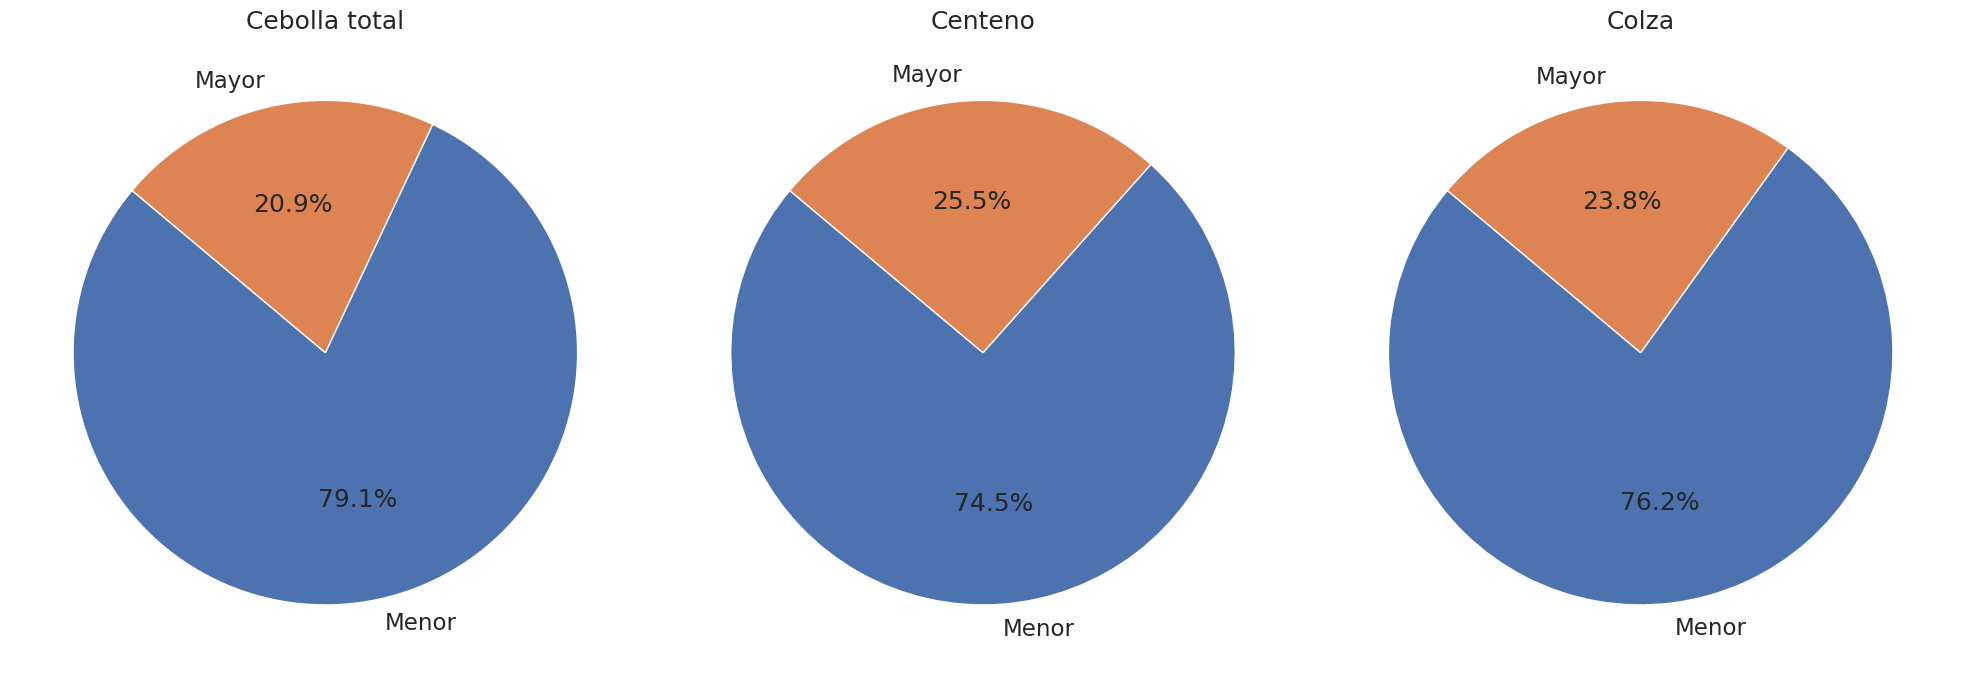

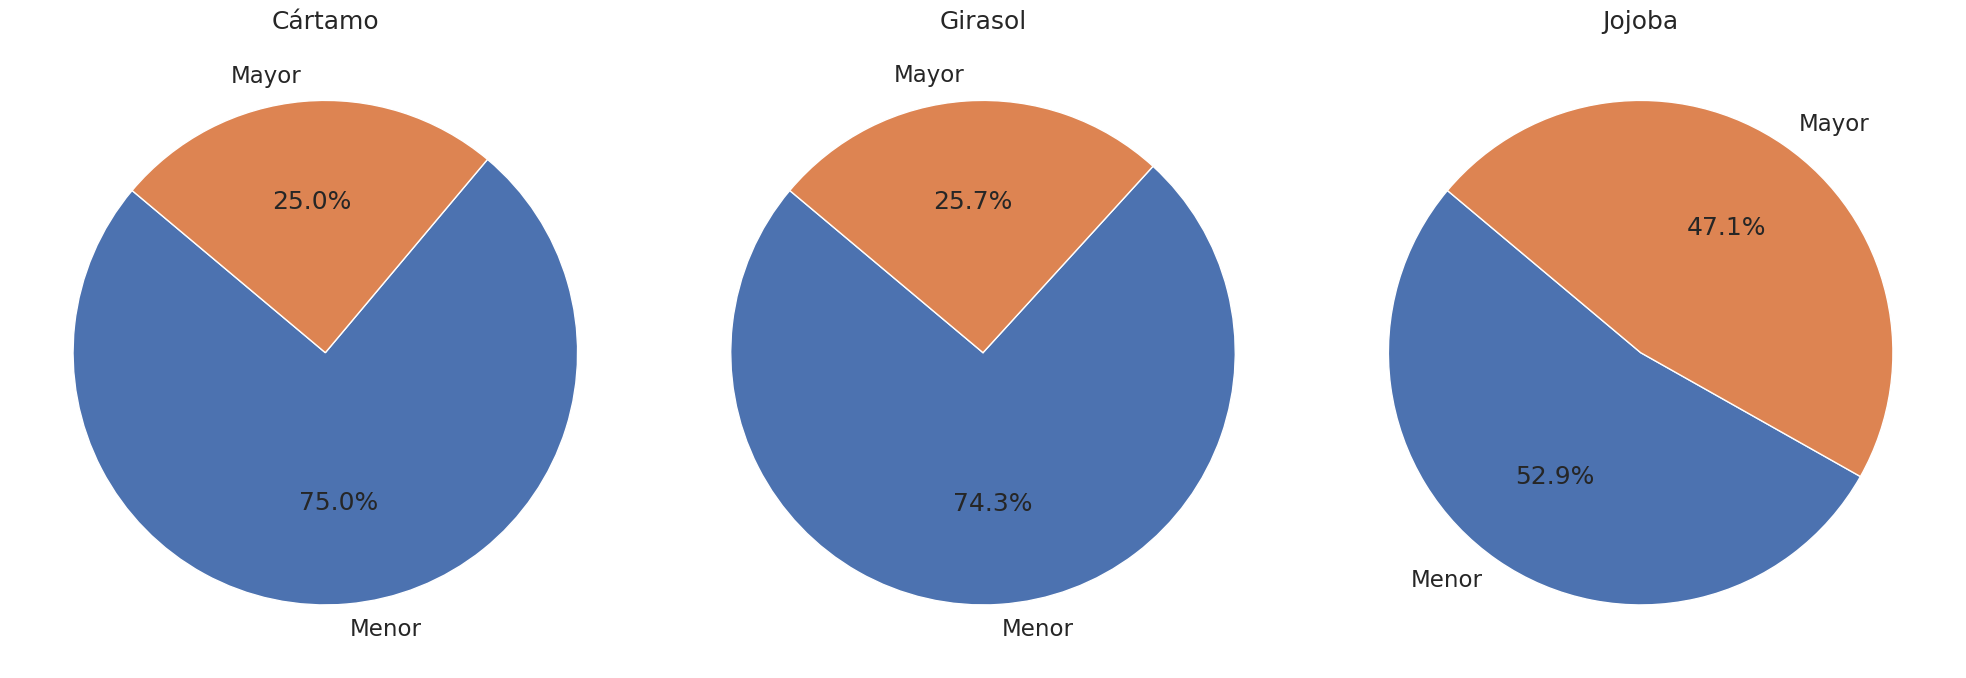

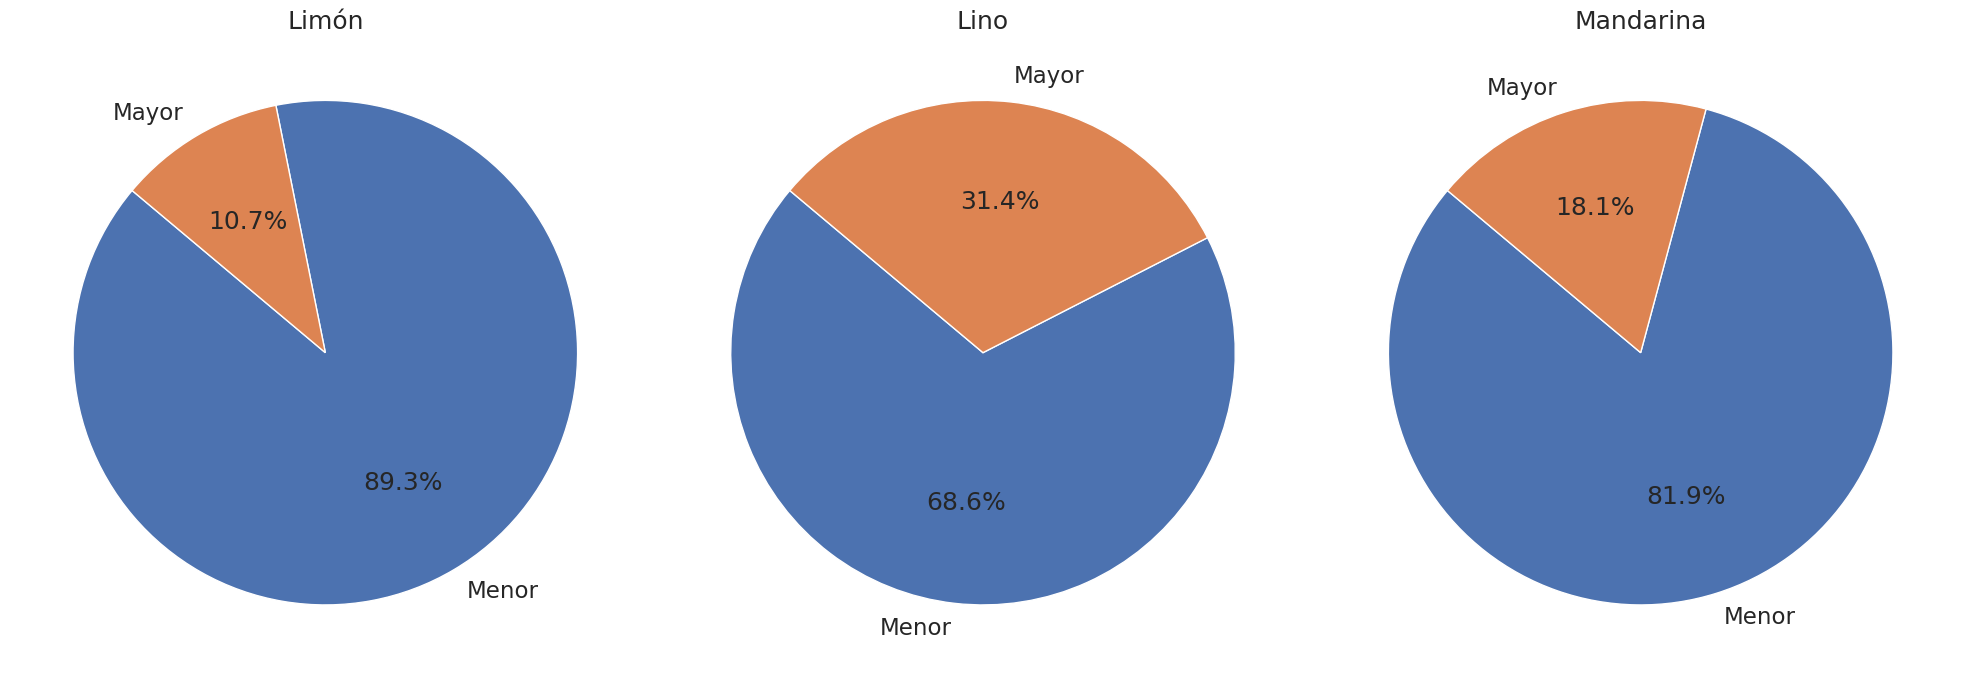

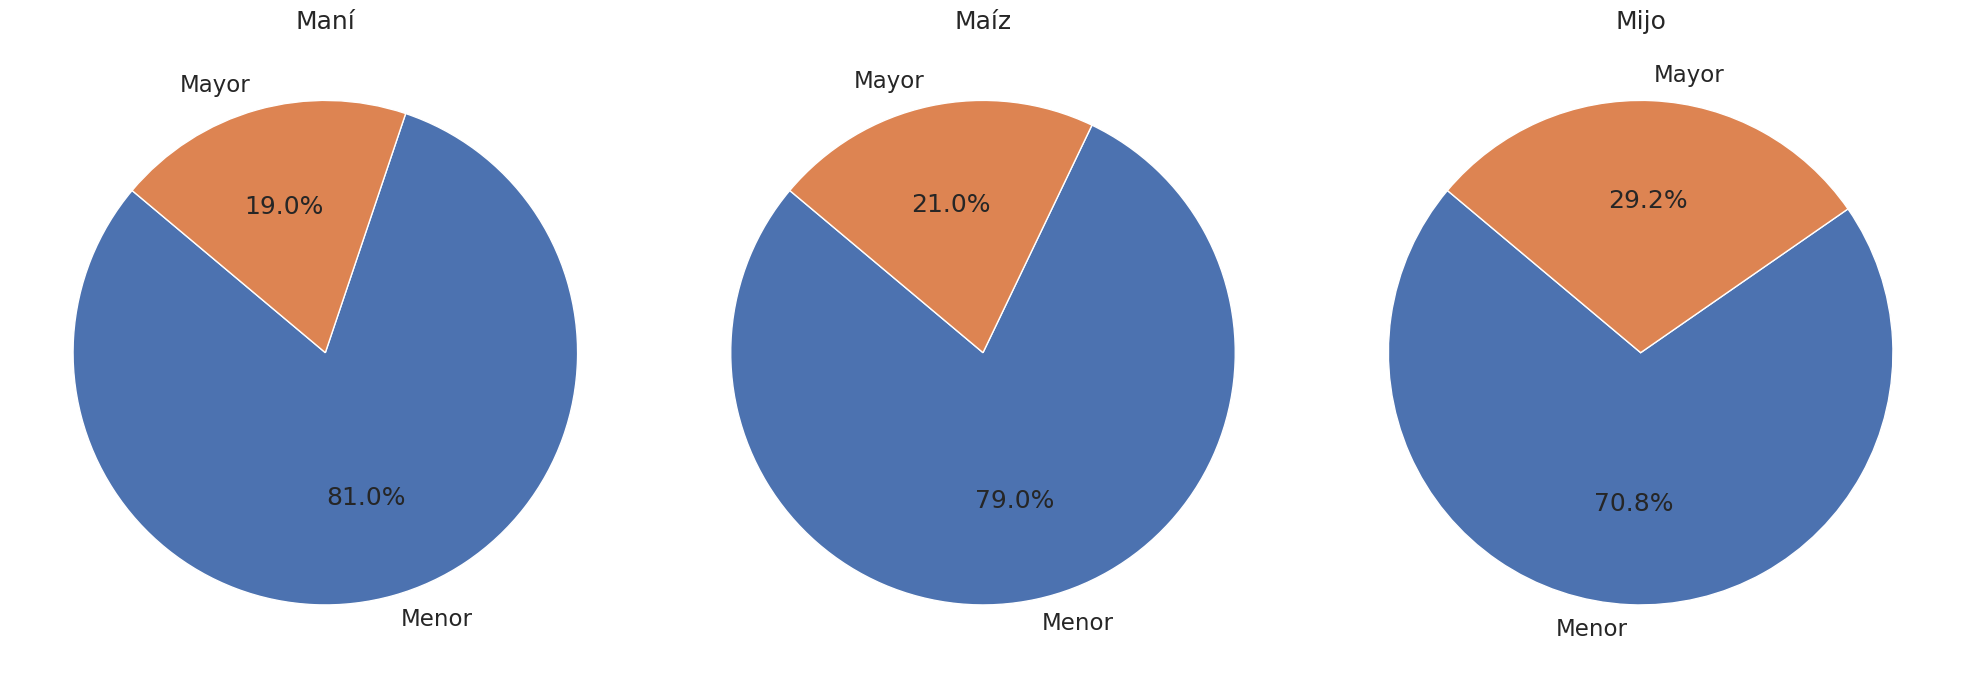

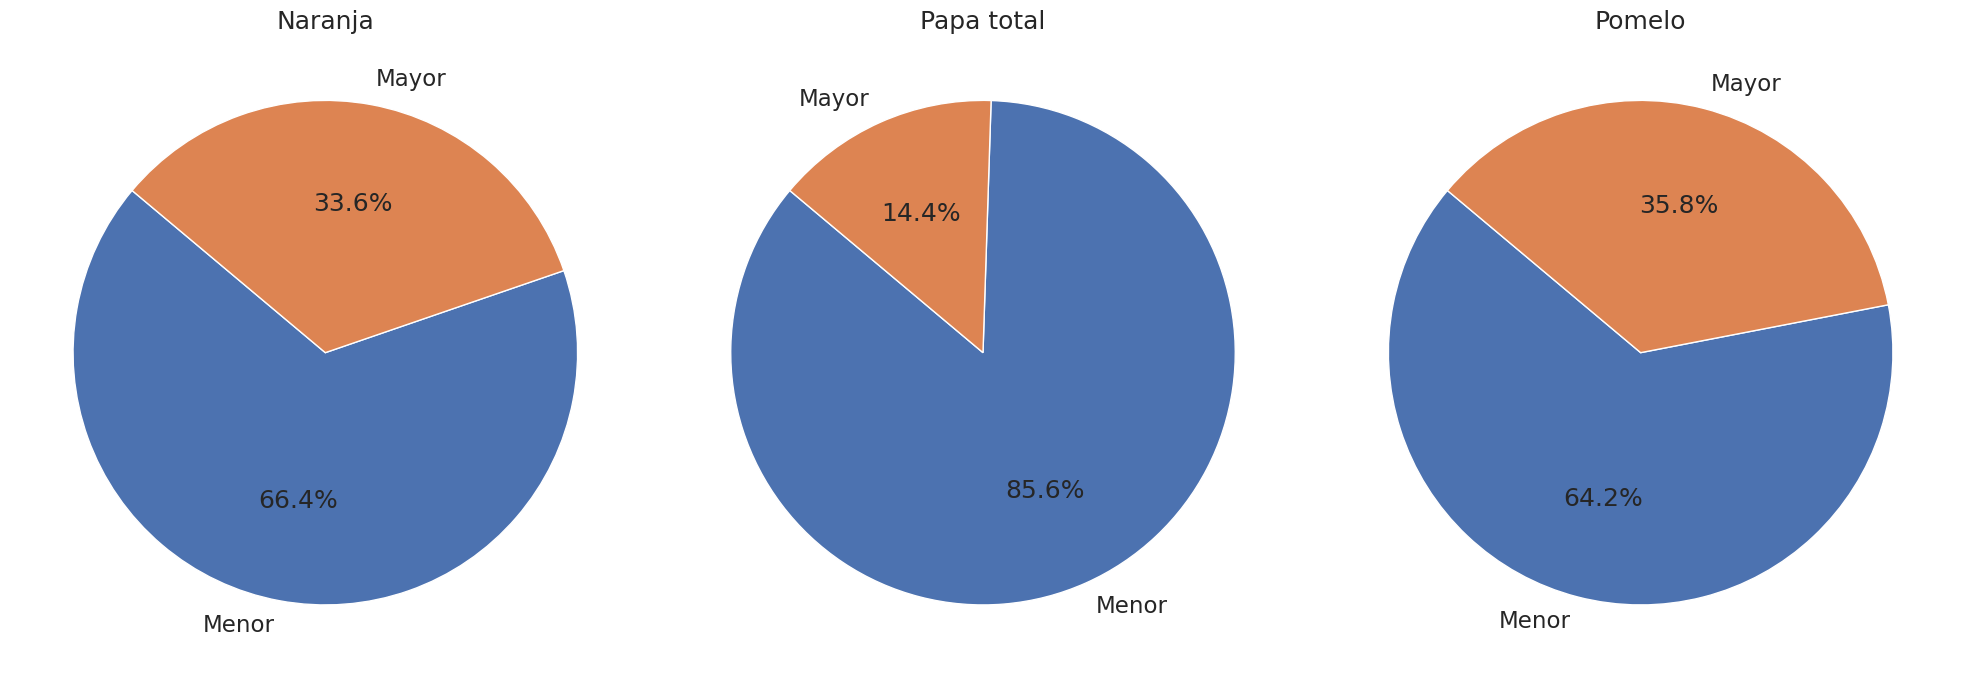

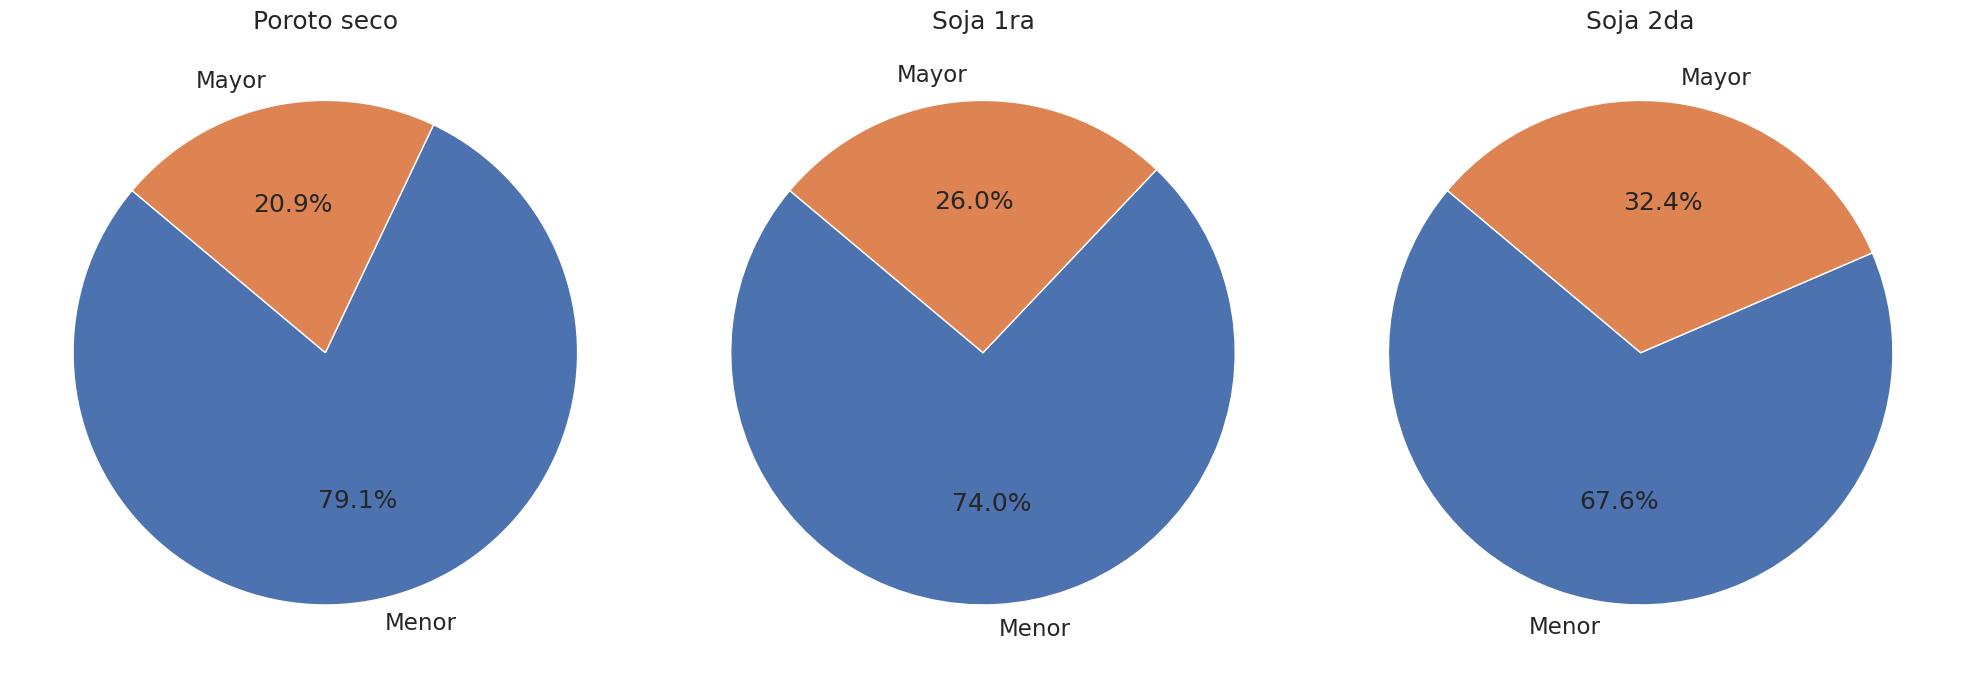

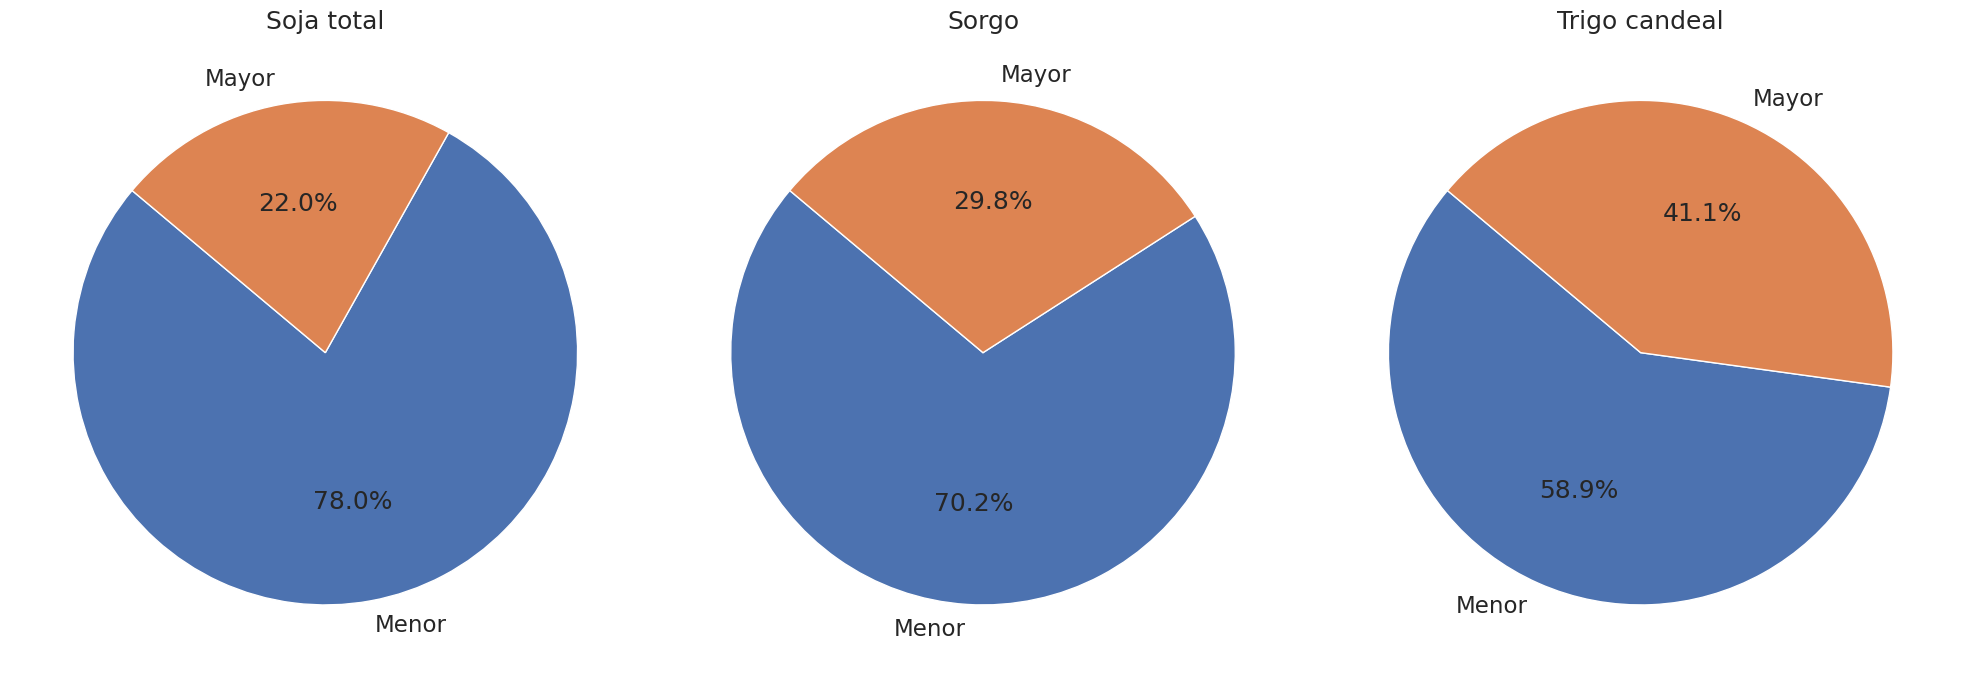

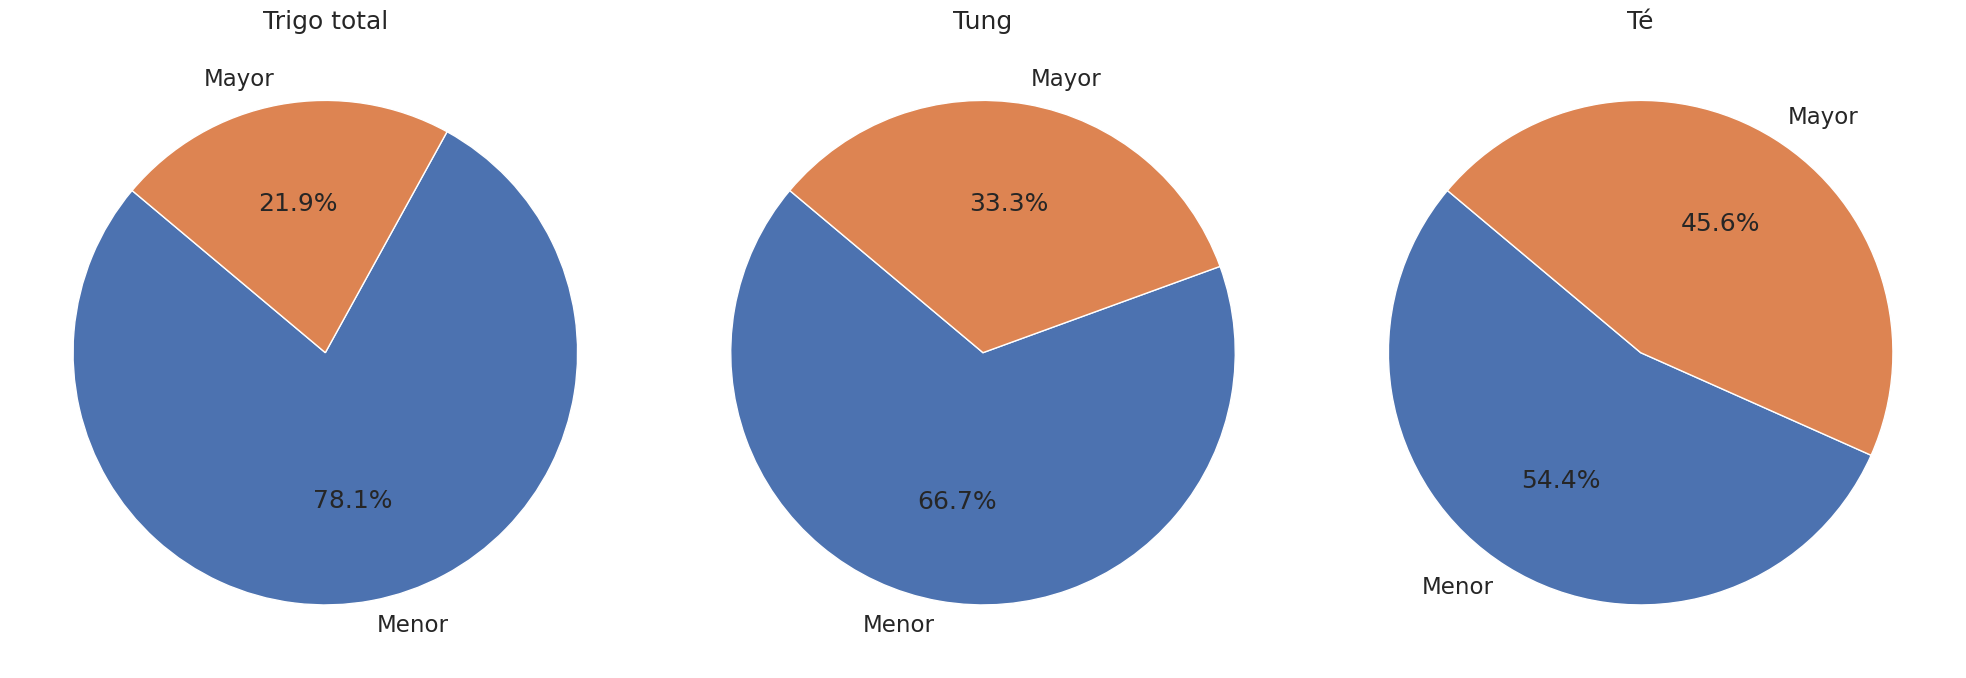

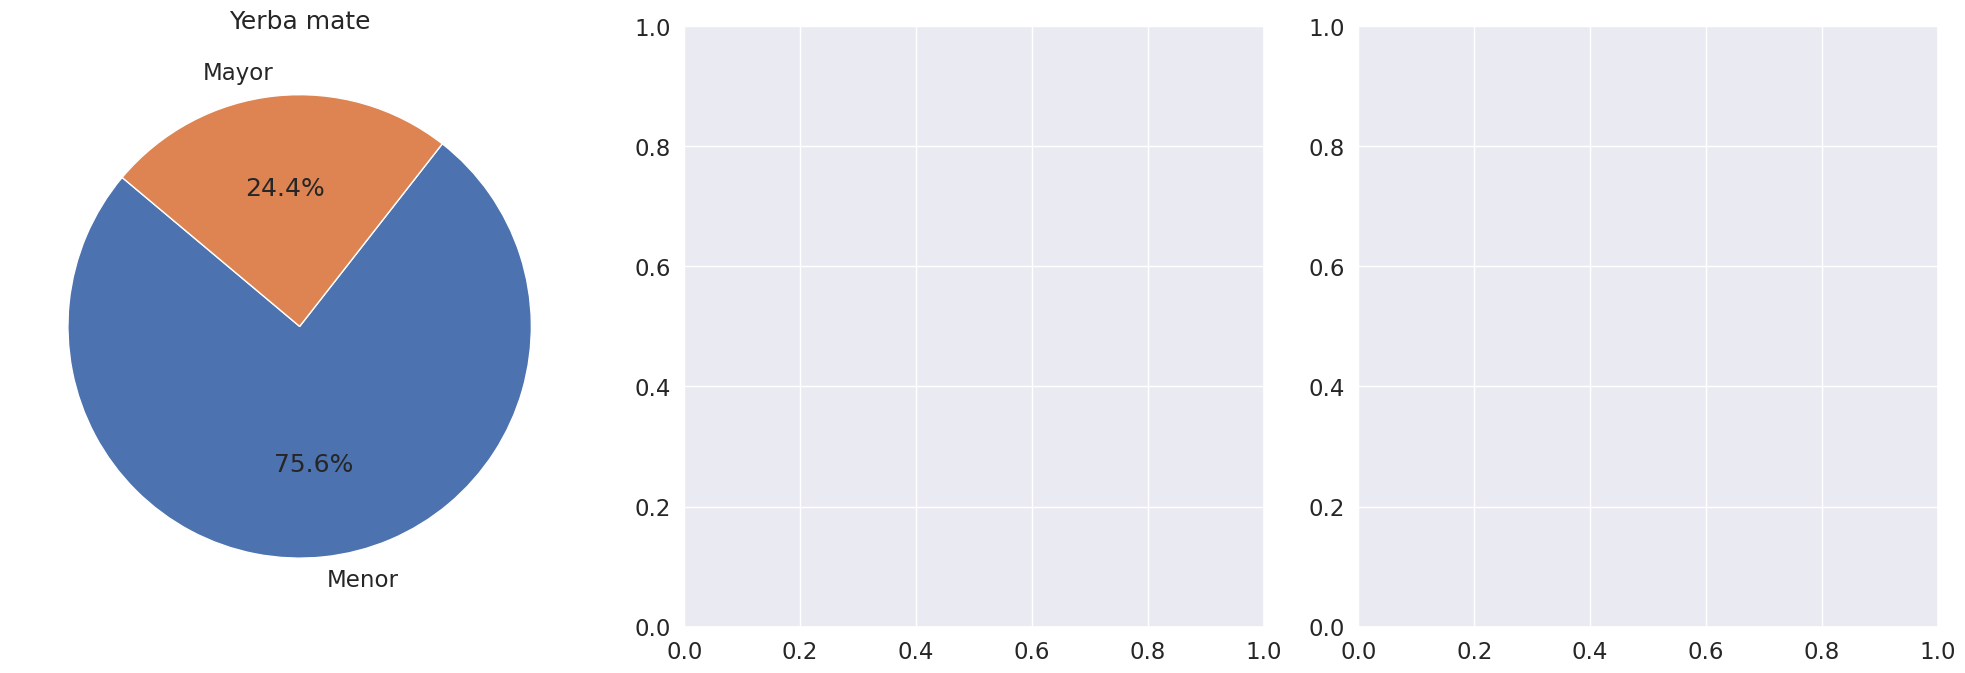

In [44]:
# Calcular la media de producción para cada cultivo
media_produccion = df.groupby('cultivo')['produccion'].mean()

# Obtener la lista de cultivos
cultivos = media_produccion.index.tolist()

# Calcular la cantidad de figuras necesarias
num_figuras = (len(cultivos) + 2) // 3  # División redondeada hacia arriba

# Crear las figuras con subplots
for fig_idx in range(num_figuras):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
    
    # Iterar sobre cada subplot
    for idx, ax in enumerate(axes):
        cultivo_idx = fig_idx * 3 + idx
        if cultivo_idx < len(cultivos):
            cultivo = cultivos[cultivo_idx]
            # Filtrar los datos para el cultivo actual y calcular la clasificación
            produccion_cultivo = df[df['cultivo'] == cultivo]['produccion']
            media_cultivo = media_produccion[cultivo]
            produccion_clasificada = produccion_cultivo.apply(lambda x: 'Mayor' if x > media_cultivo else 'Menor')
            # Contar la frecuencia de cada clasificación
            conteo = produccion_clasificada.value_counts()
            # Crear el gráfico de torta
            ax.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=140)
            ax.set_title(cultivo)
    
    plt.tight_layout()
    plt.show()


## Rendimiento por tipo de suelo y cultivo

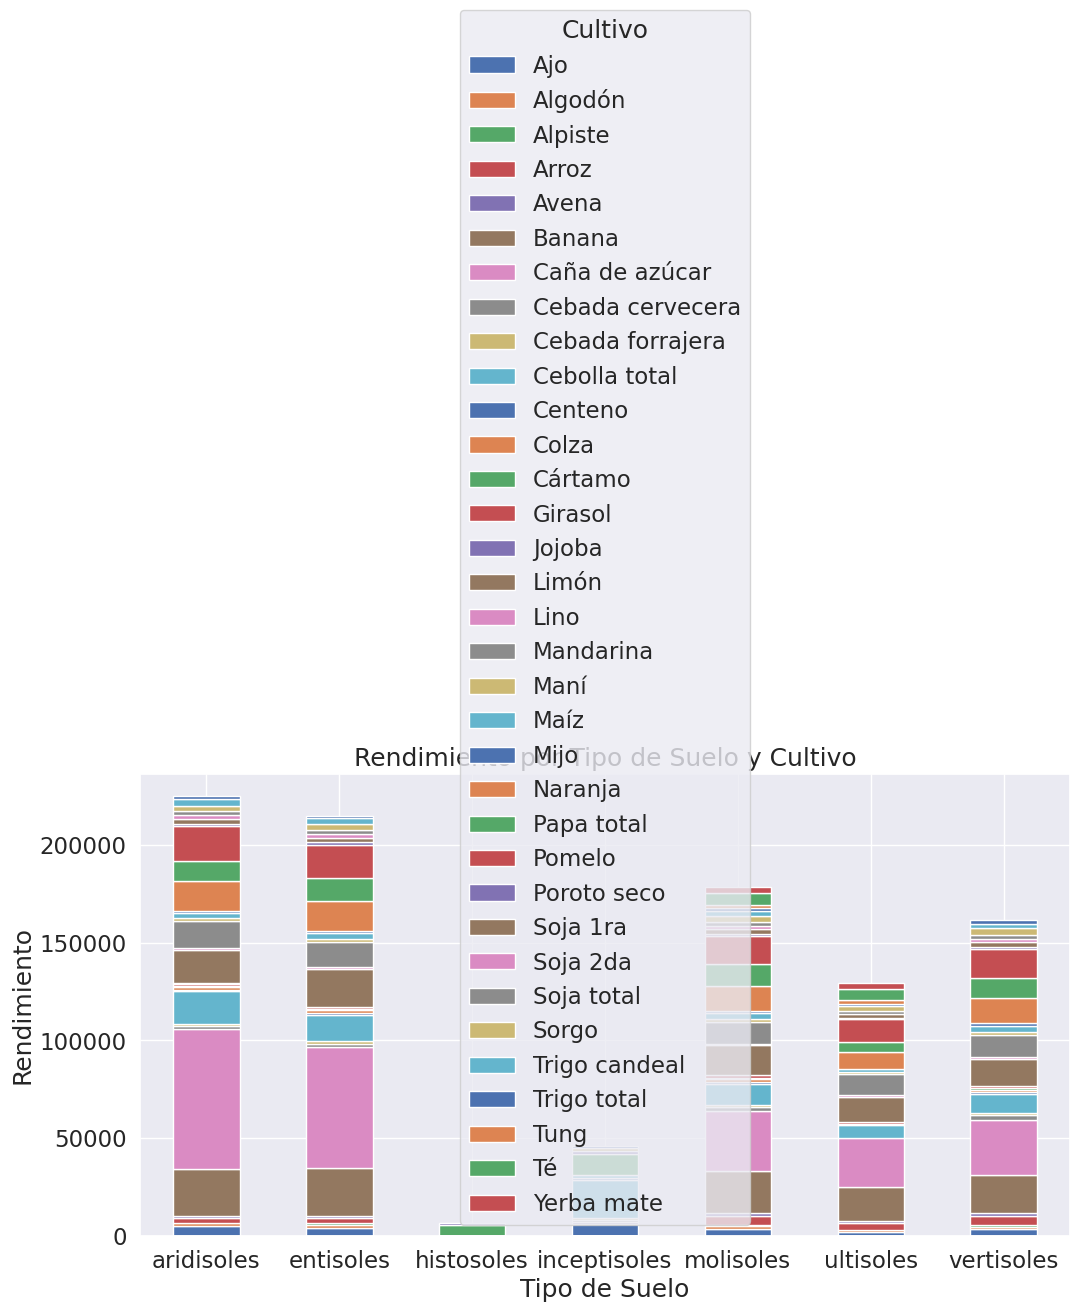

In [45]:
# Convertir los tipos de suelos en formato largo
df_long = df.melt(id_vars=['año_inicio', 'año_fin', 'provincia', 'cultivo', 'sup_sembrada', 'sup_cosechada', 'produccion', 'rendimiento', 'temperatura'],
                  value_vars=['molisoles', 'vertisoles', 'entisoles', 'aridisoles', 'ultisoles', 'inceptisoles', 'histosoles'],
                  var_name='tipo_suelo', value_name='presencia')

# Filtrar donde la presencia del tipo de suelo es 1
df_suelo = df_long[df_long['presencia'] == 1]

# Crear una tabla pivot para obtener el rendimiento por tipo de suelo y cultivo
pivot_table = df_suelo.pivot_table(values='rendimiento', index='tipo_suelo', columns='cultivo', aggfunc='mean', fill_value=0)

# Crear el gráfico de barras apiladas
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Rendimiento por Tipo de Suelo y Cultivo')
plt.xlabel('Tipo de Suelo')
plt.ylabel('Rendimiento')
plt.xticks(rotation=360)
plt.legend(title='Cultivo')
plt.show()

## Temperatura vs rendimiento por cultivo

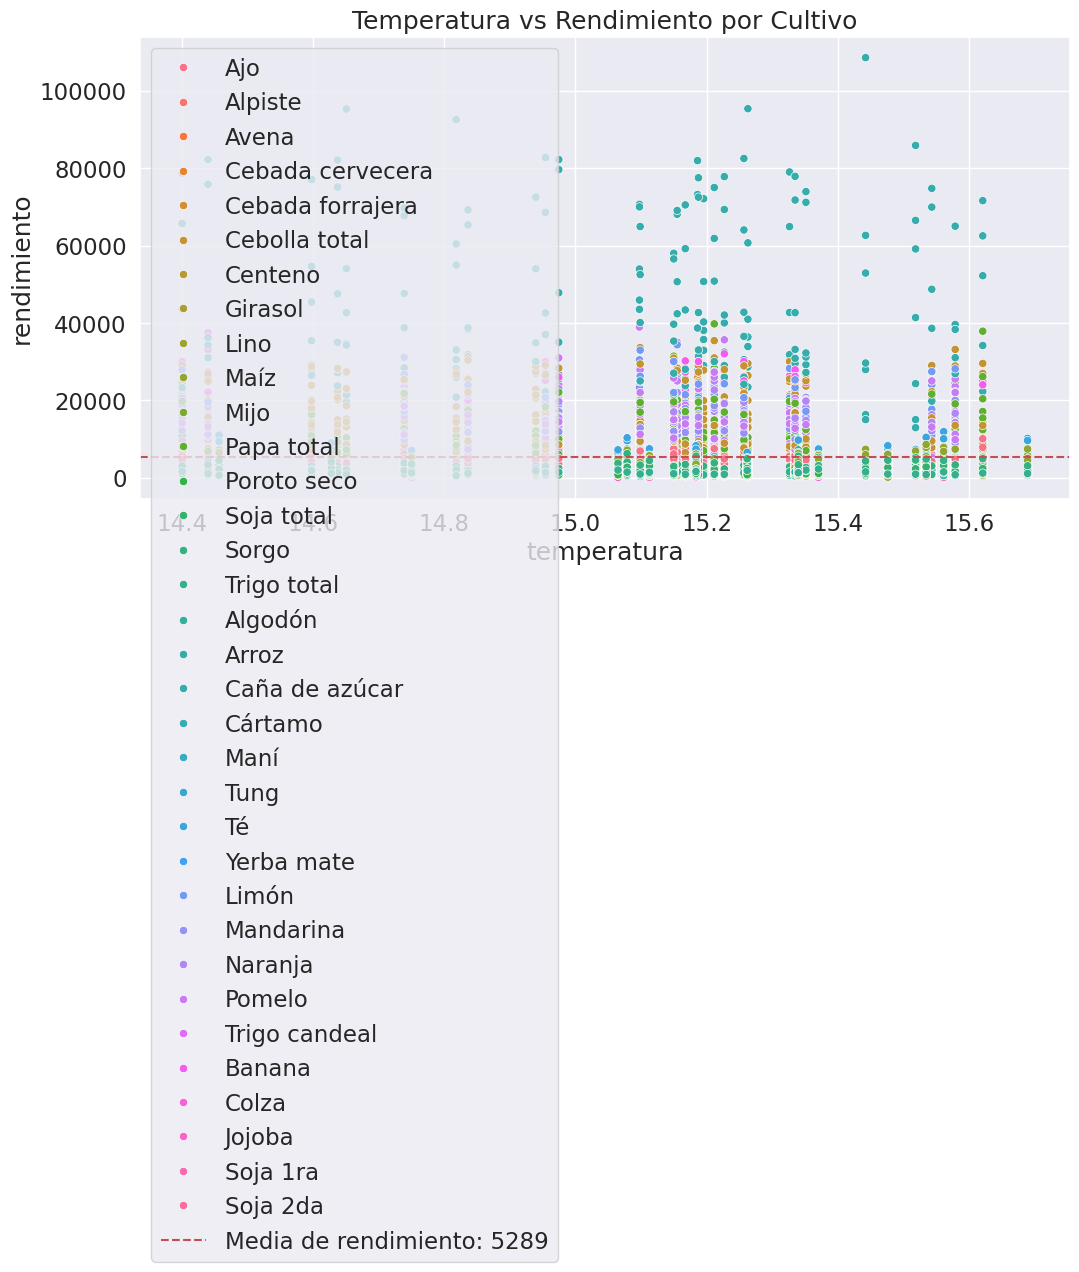

In [46]:
# Crear el gráfico de dispersión
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temperatura', y='rendimiento', hue='cultivo', data=df)
plt.title('Temperatura vs Rendimiento por Cultivo')

# Calcular y agregar la línea de la media del rendimiento
mean_rendimiento = df['rendimiento'].mean()
plt.axhline(mean_rendimiento, color='r', linestyle='--', label=f'Media de rendimiento: {mean_rendimiento:.0f}')
plt.legend()

plt.show()

## Balanceo clase nivel producción

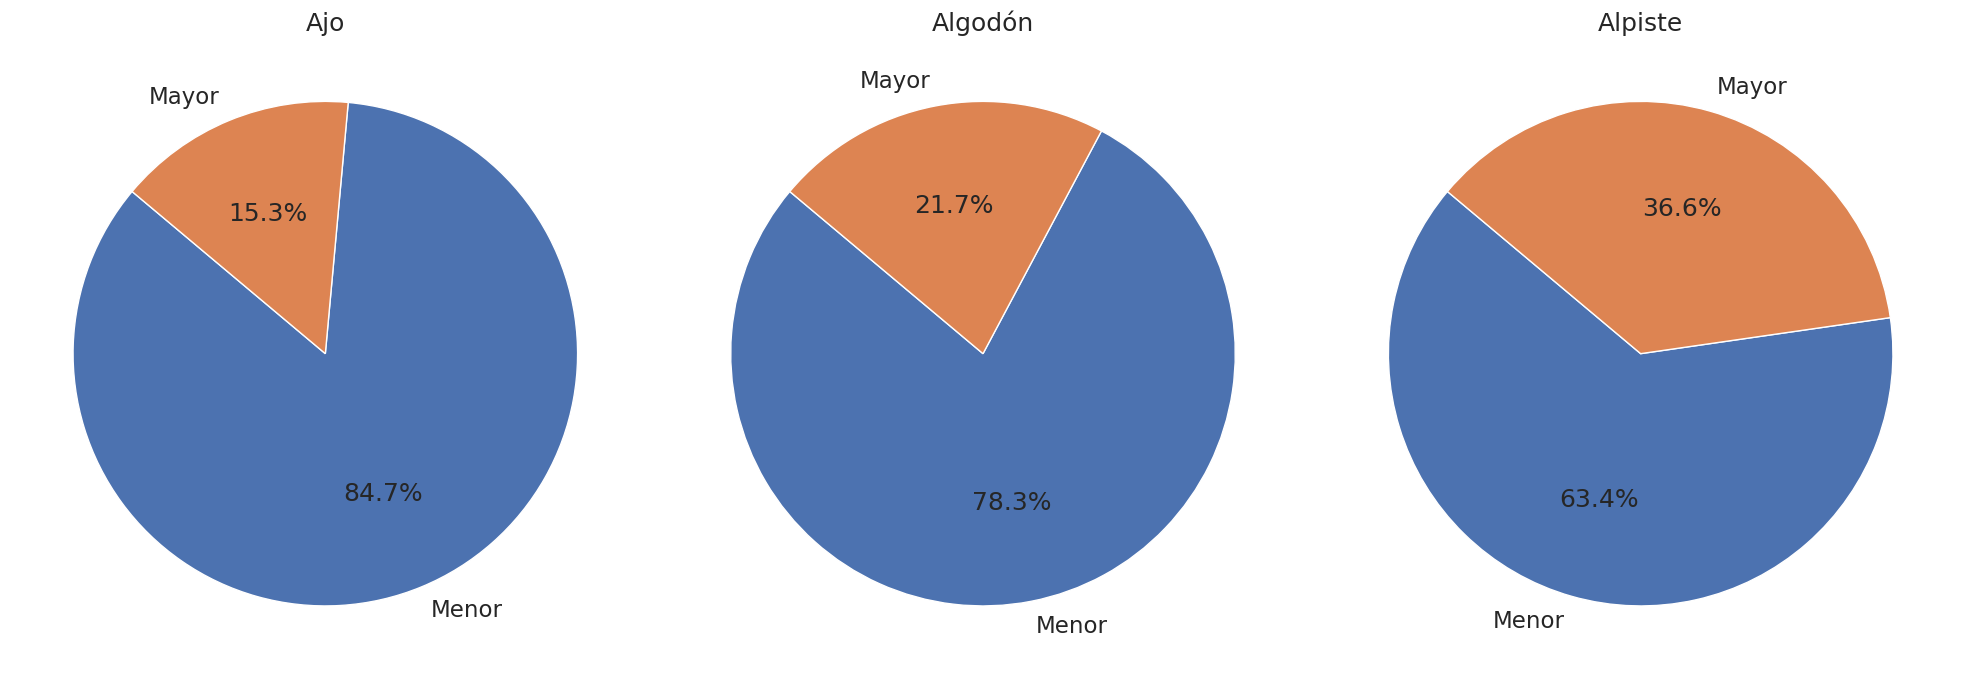

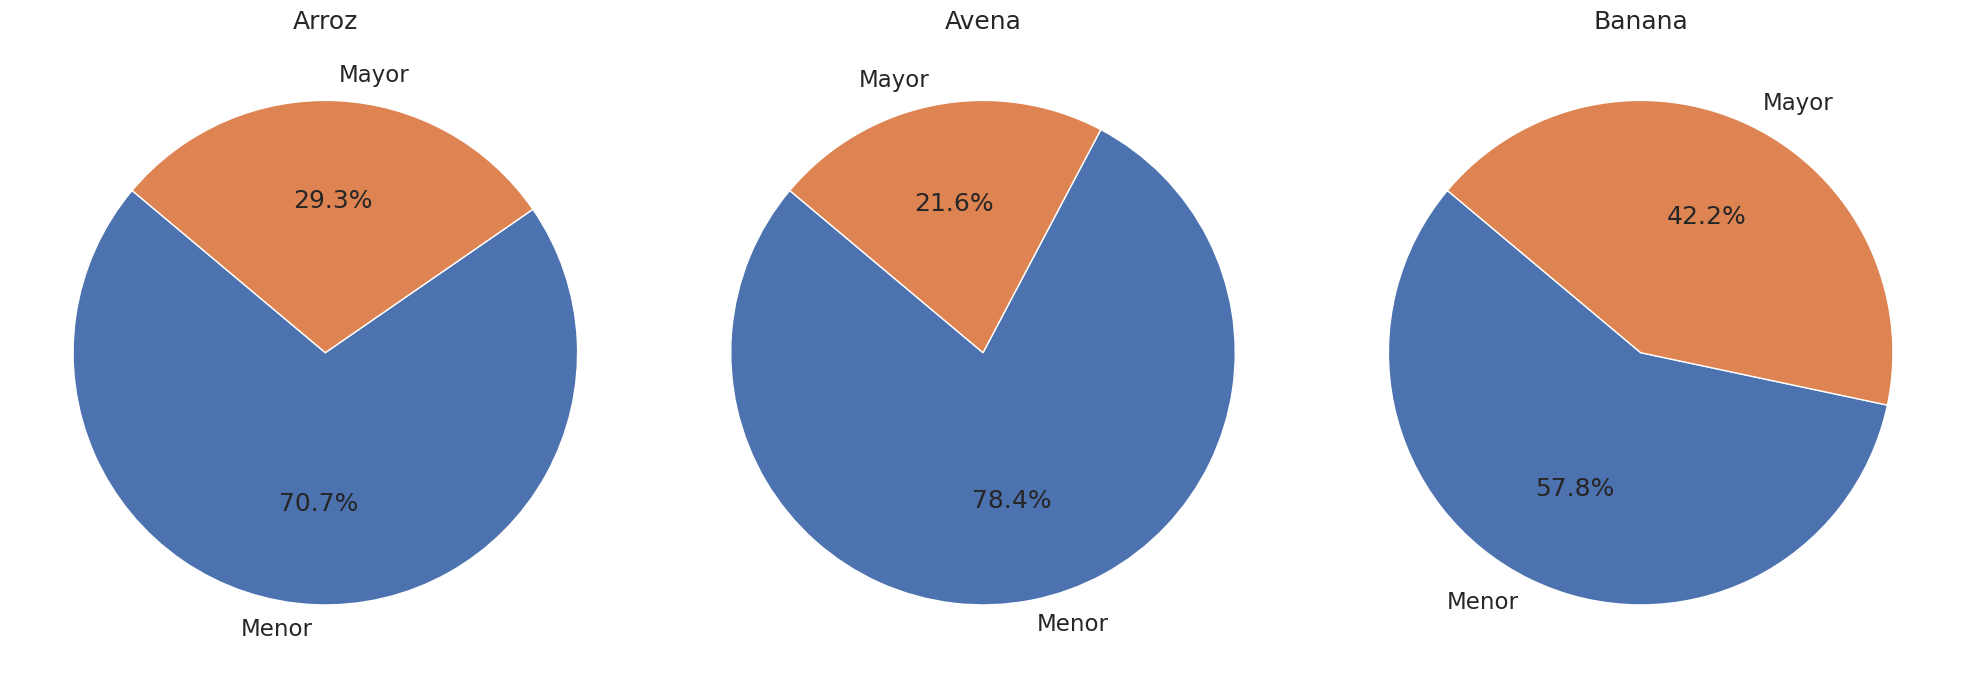

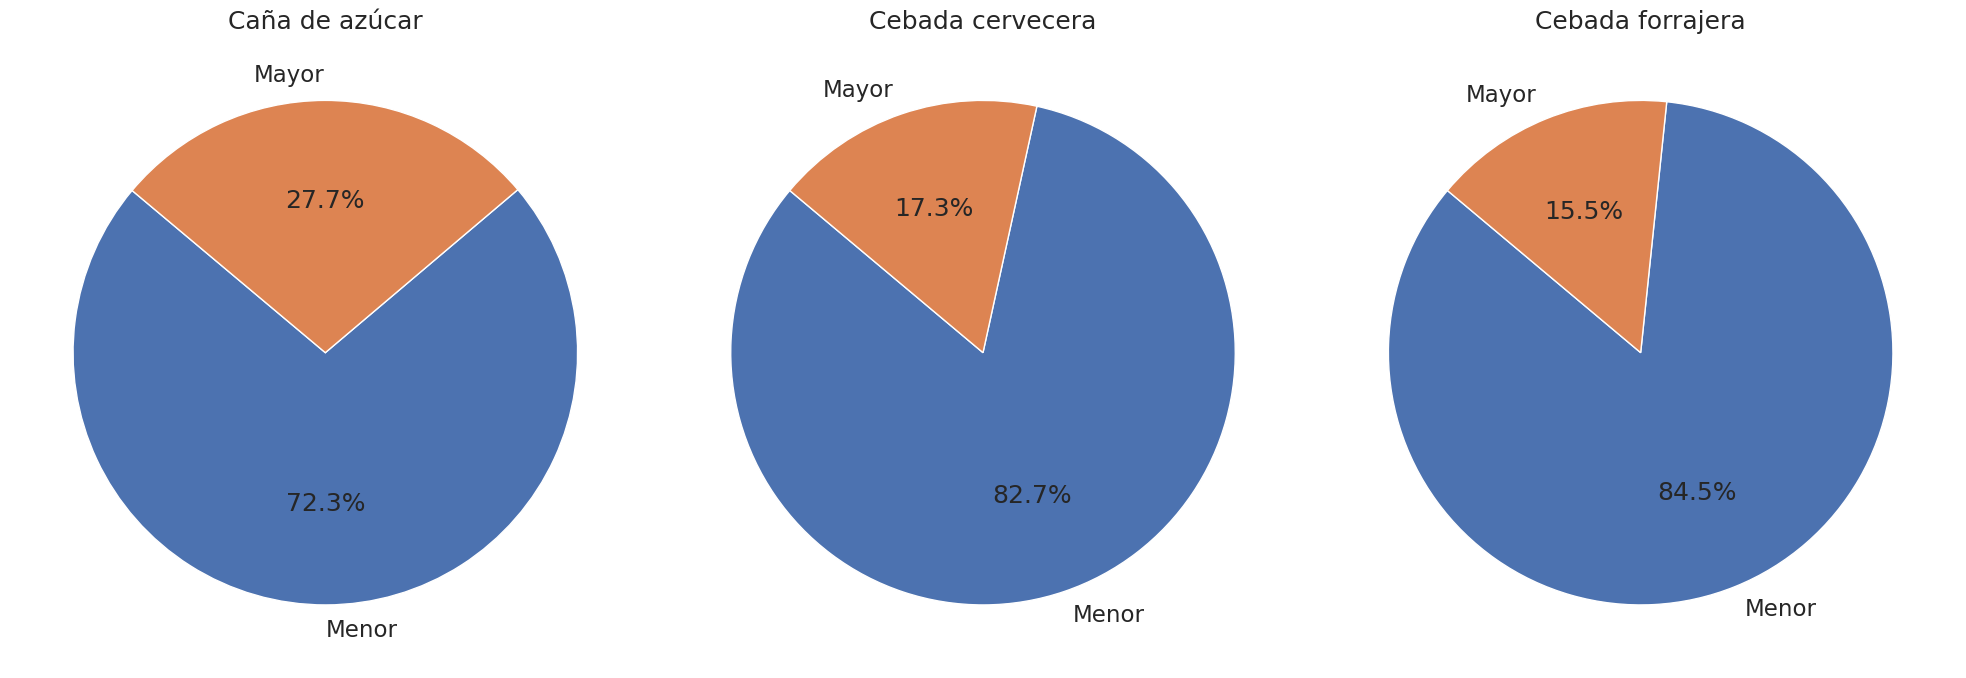

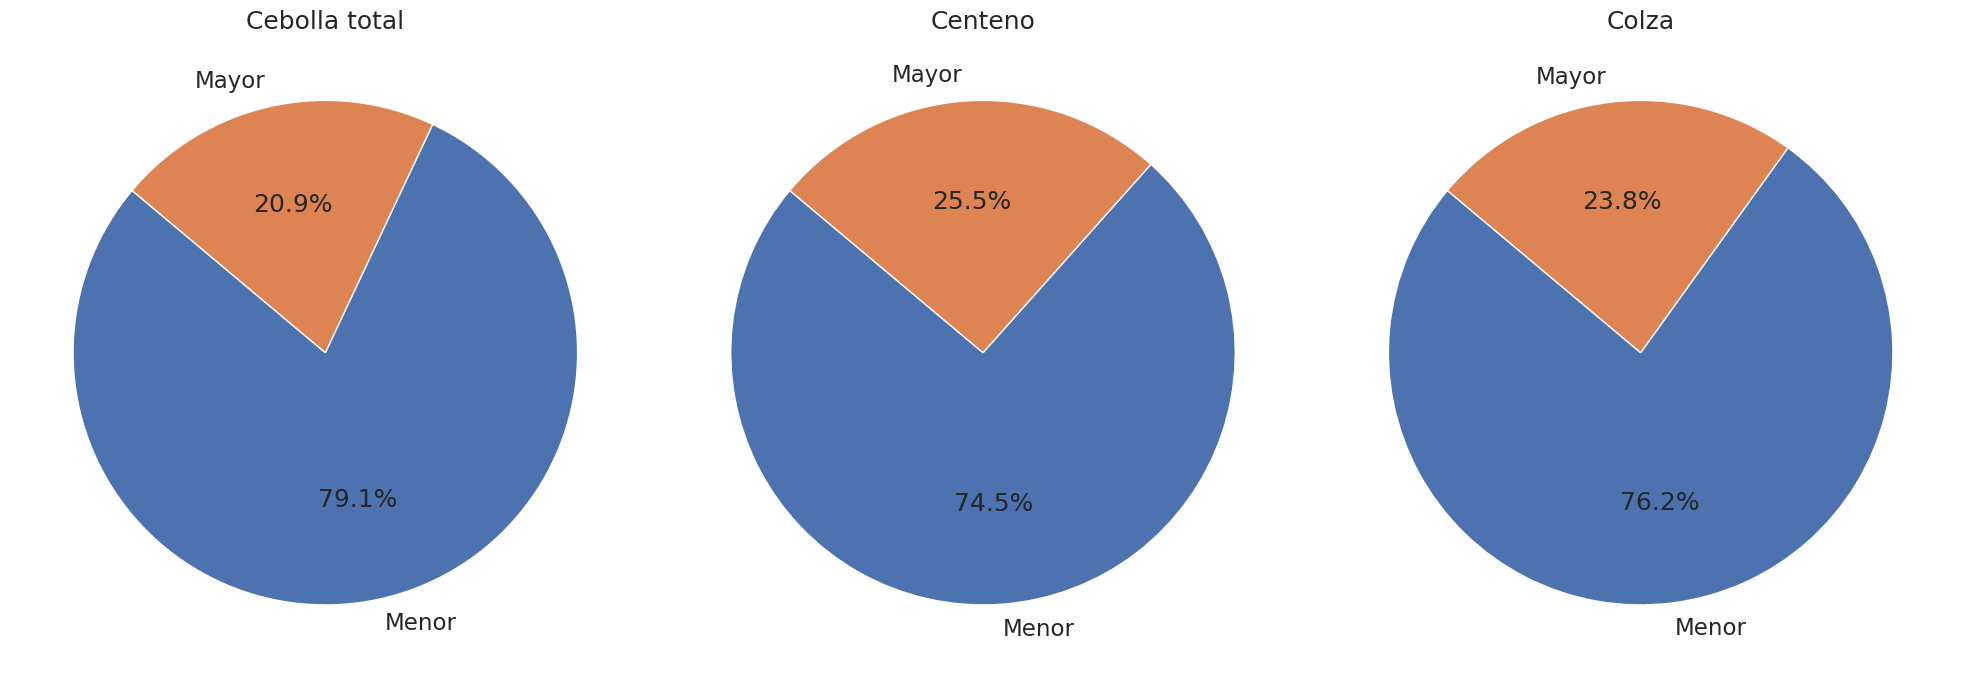

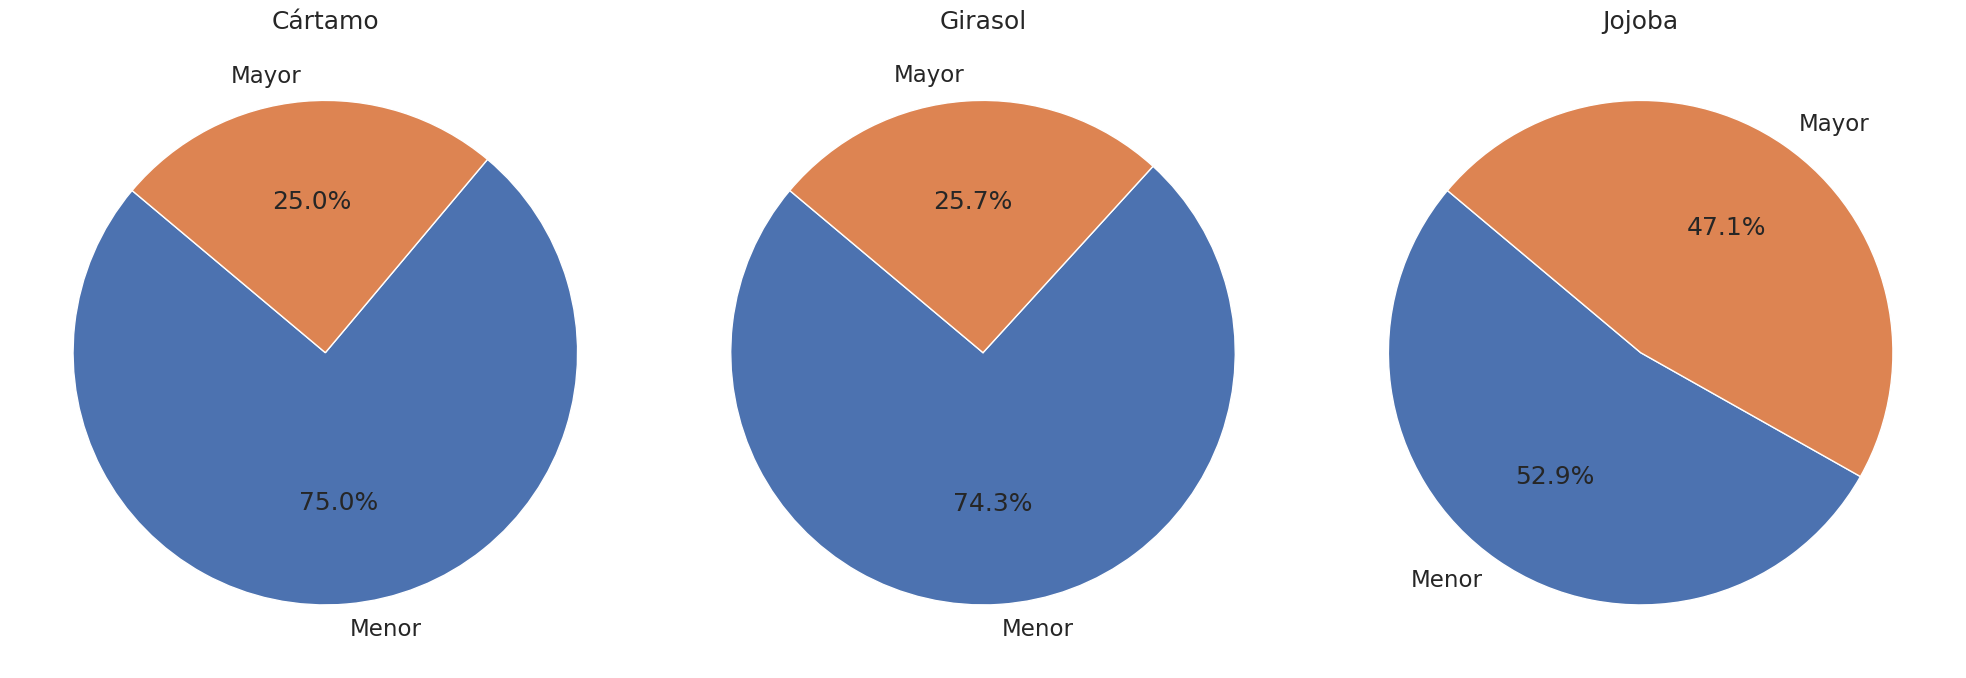

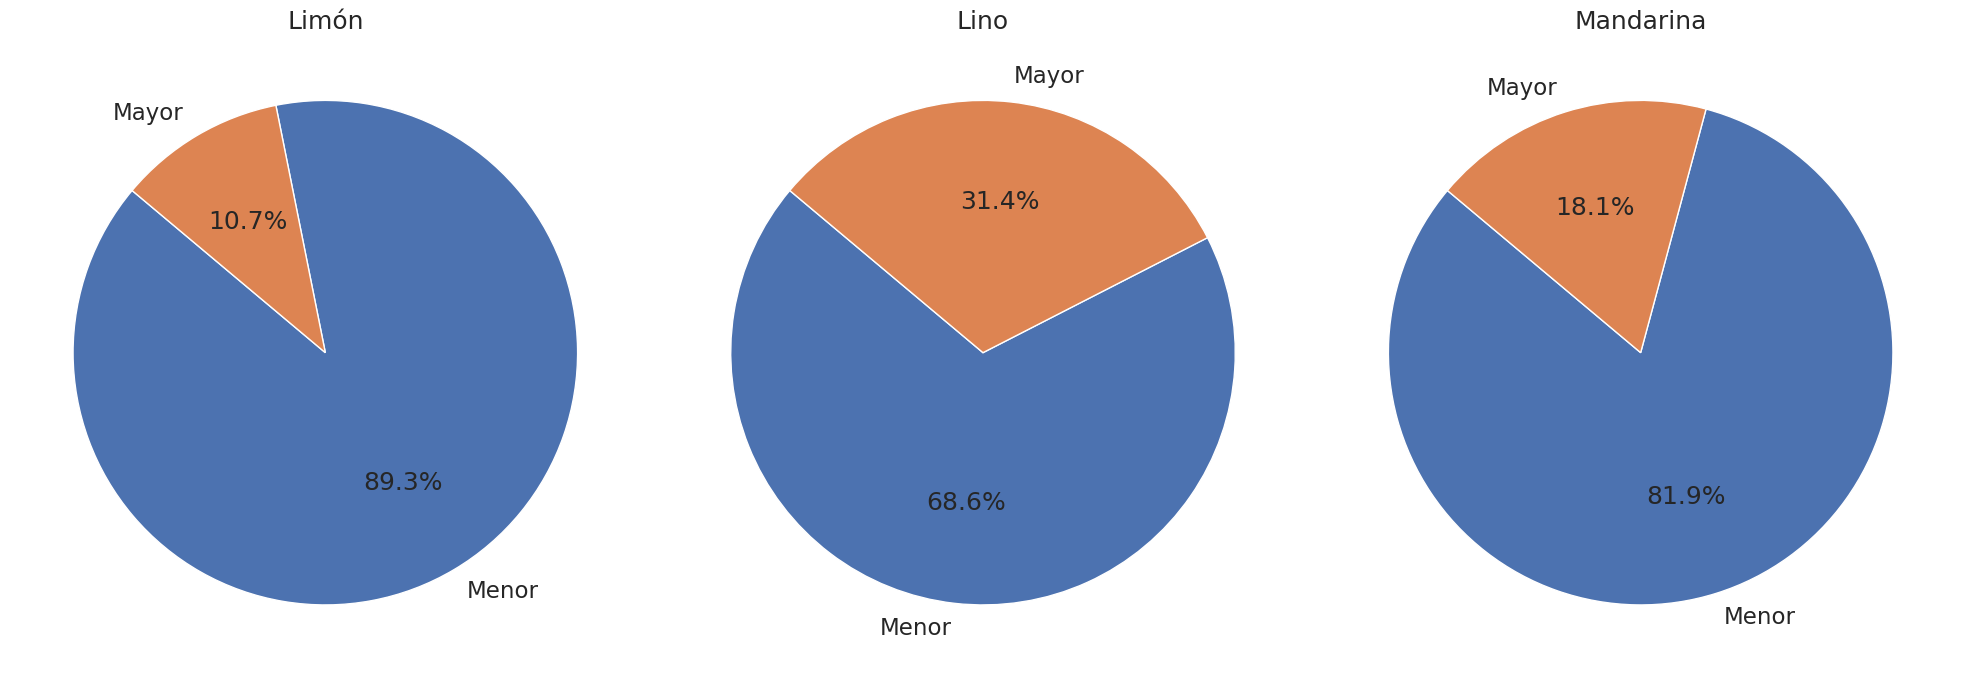

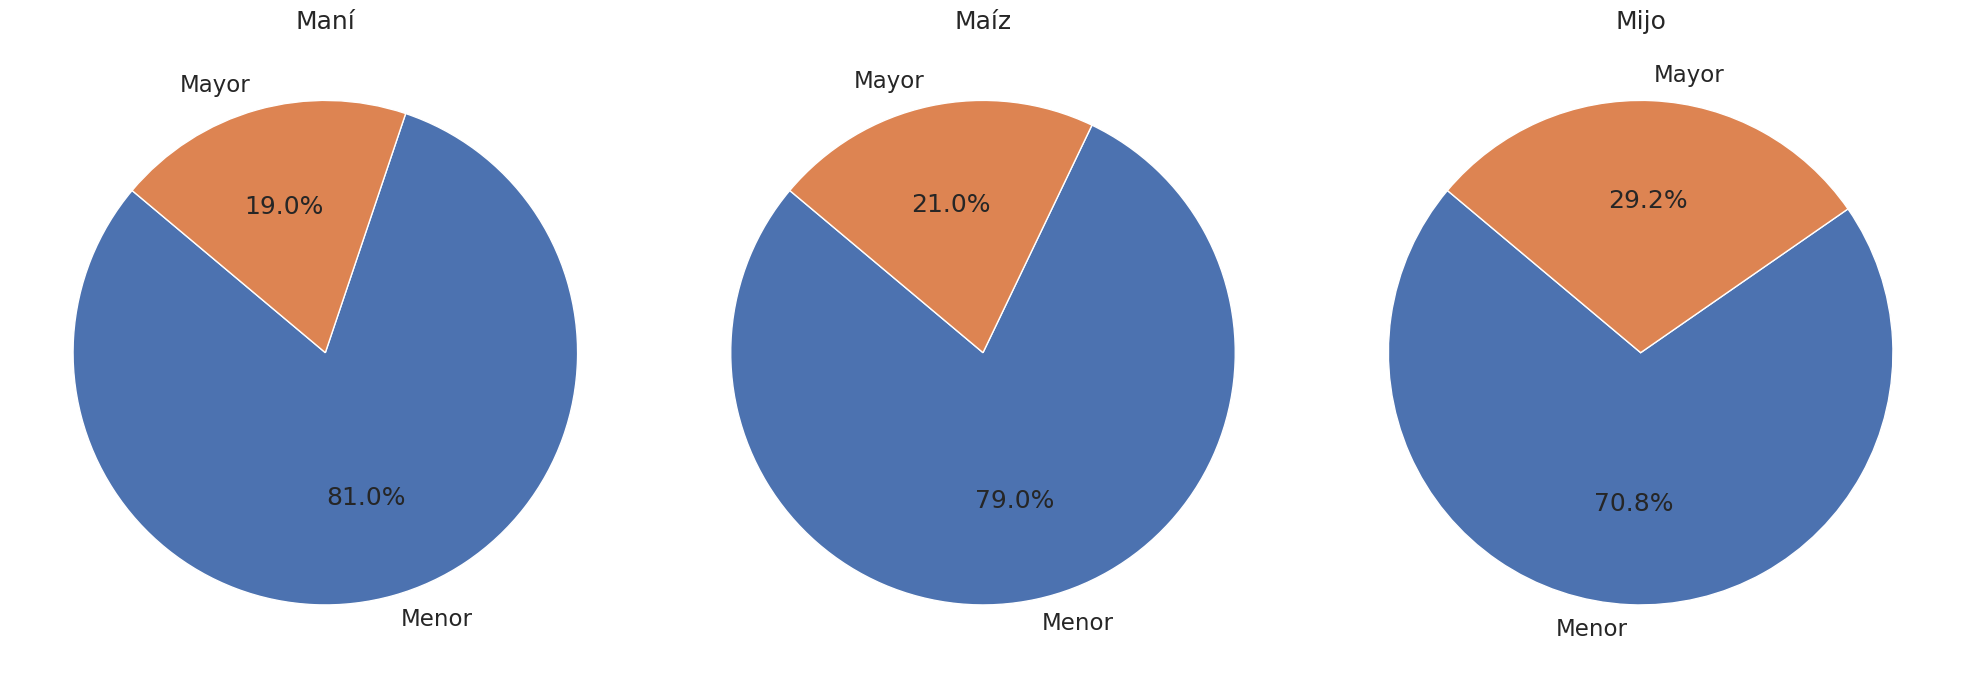

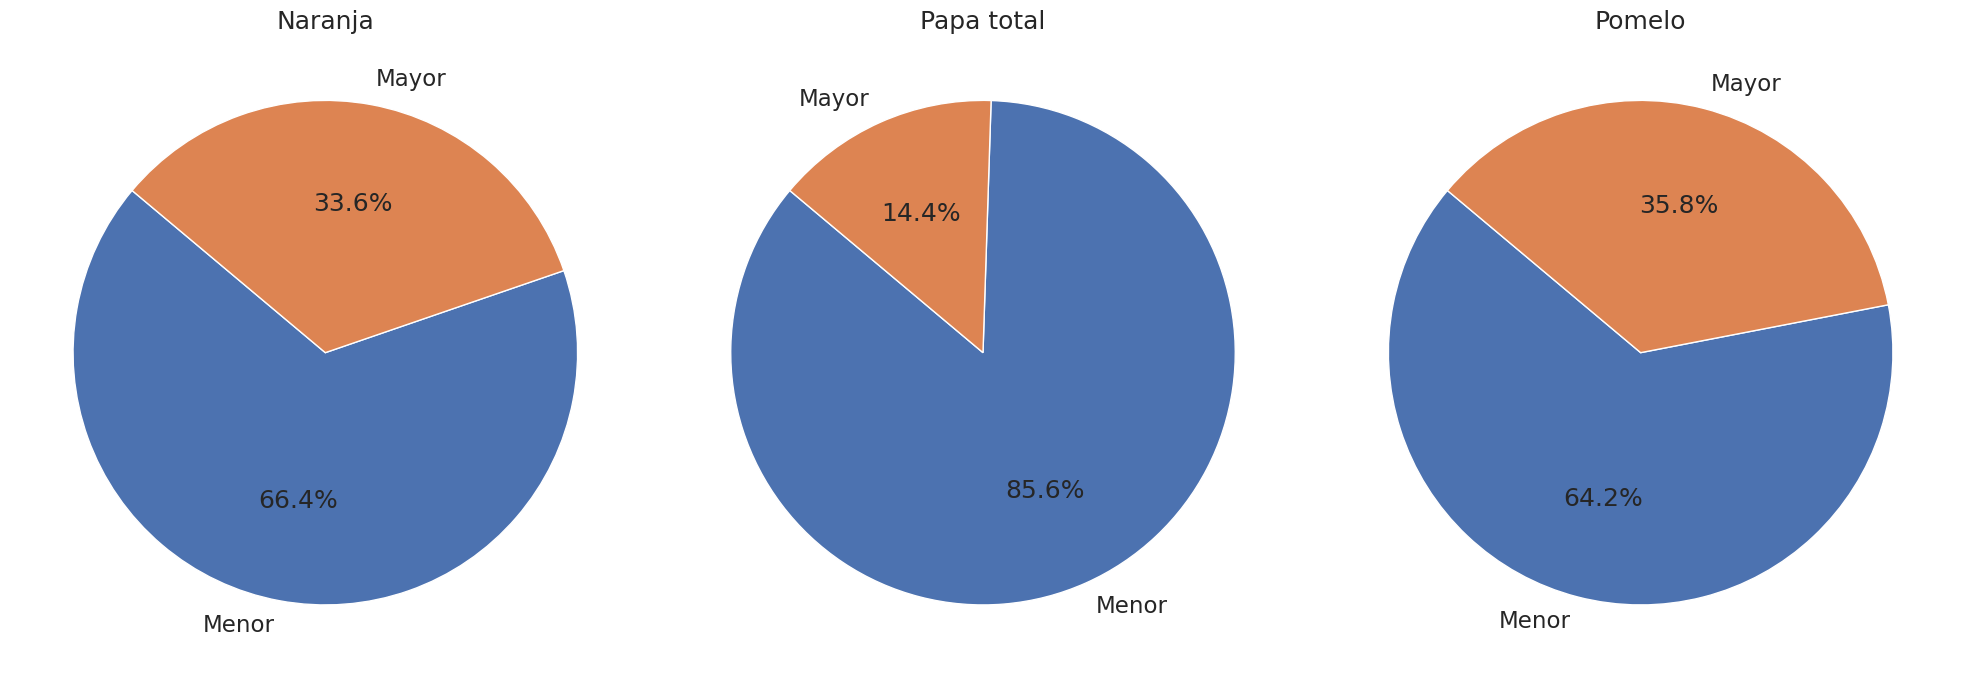

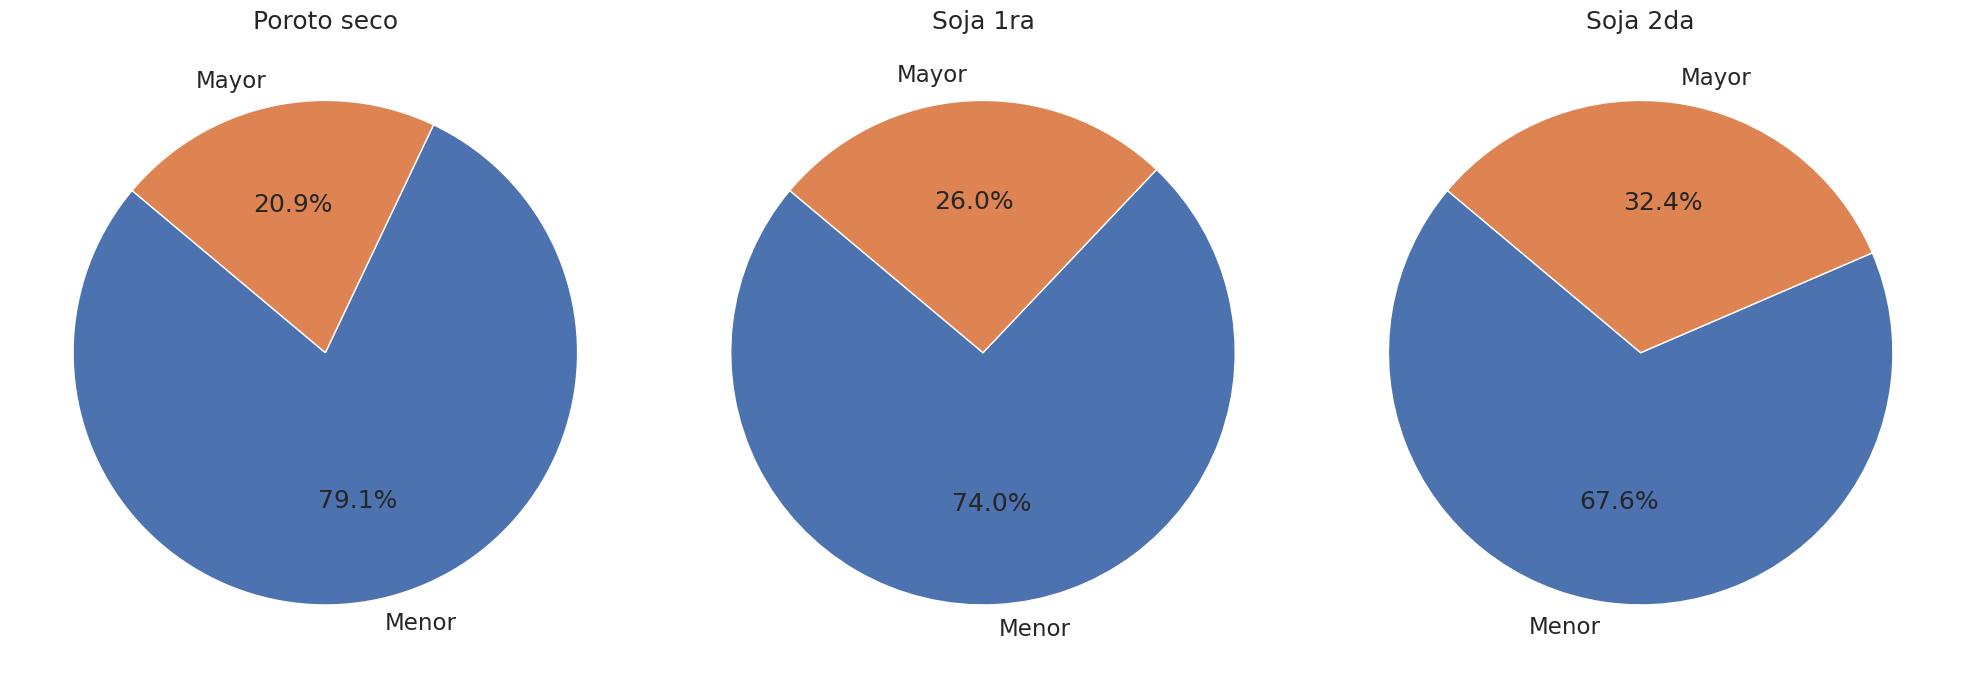

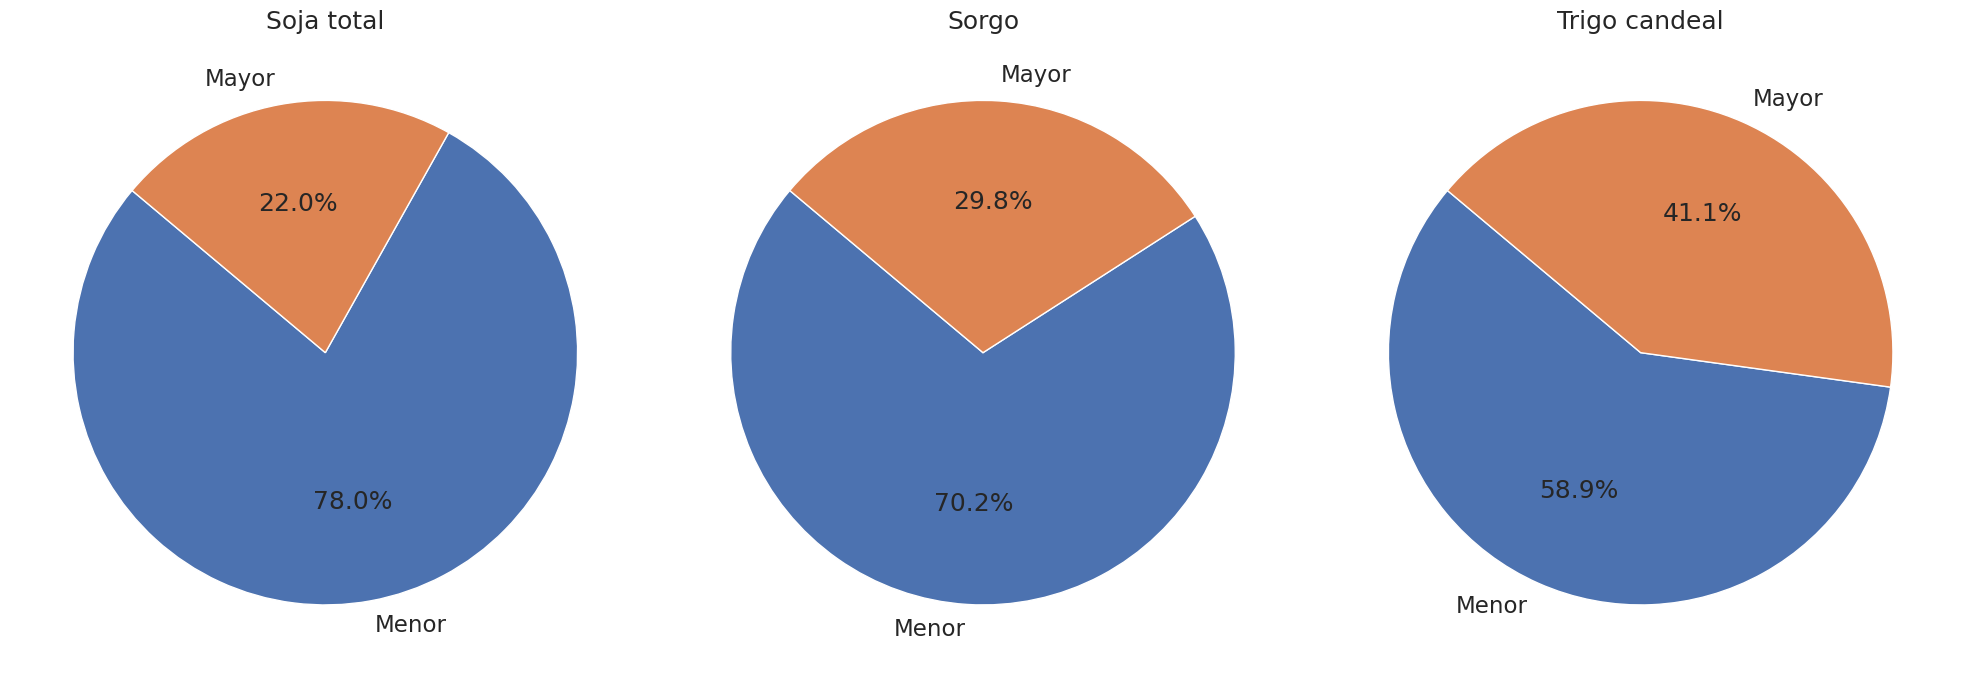

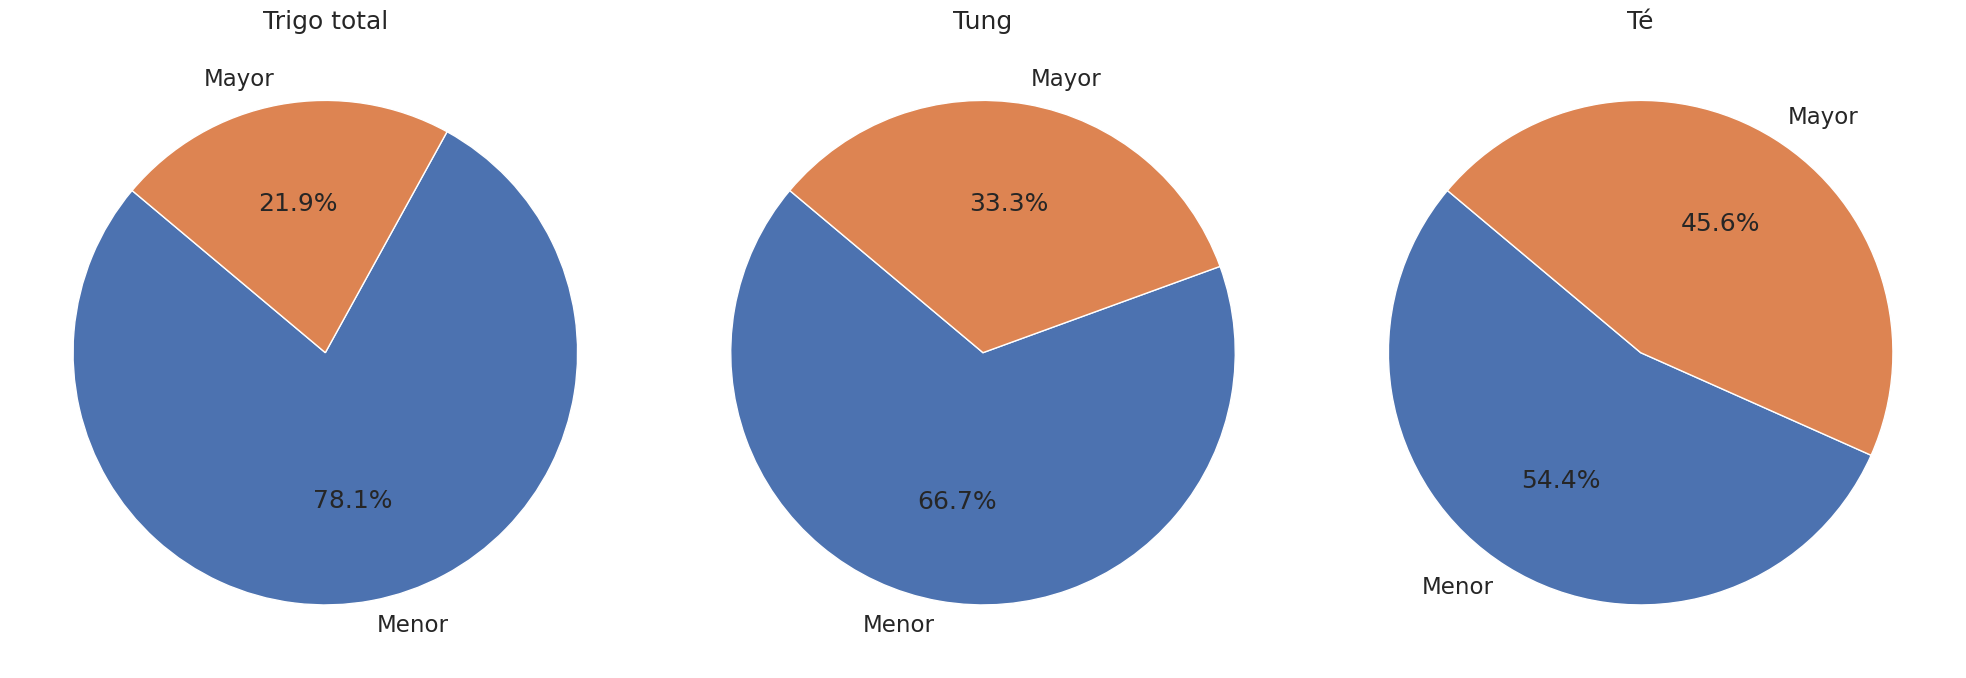

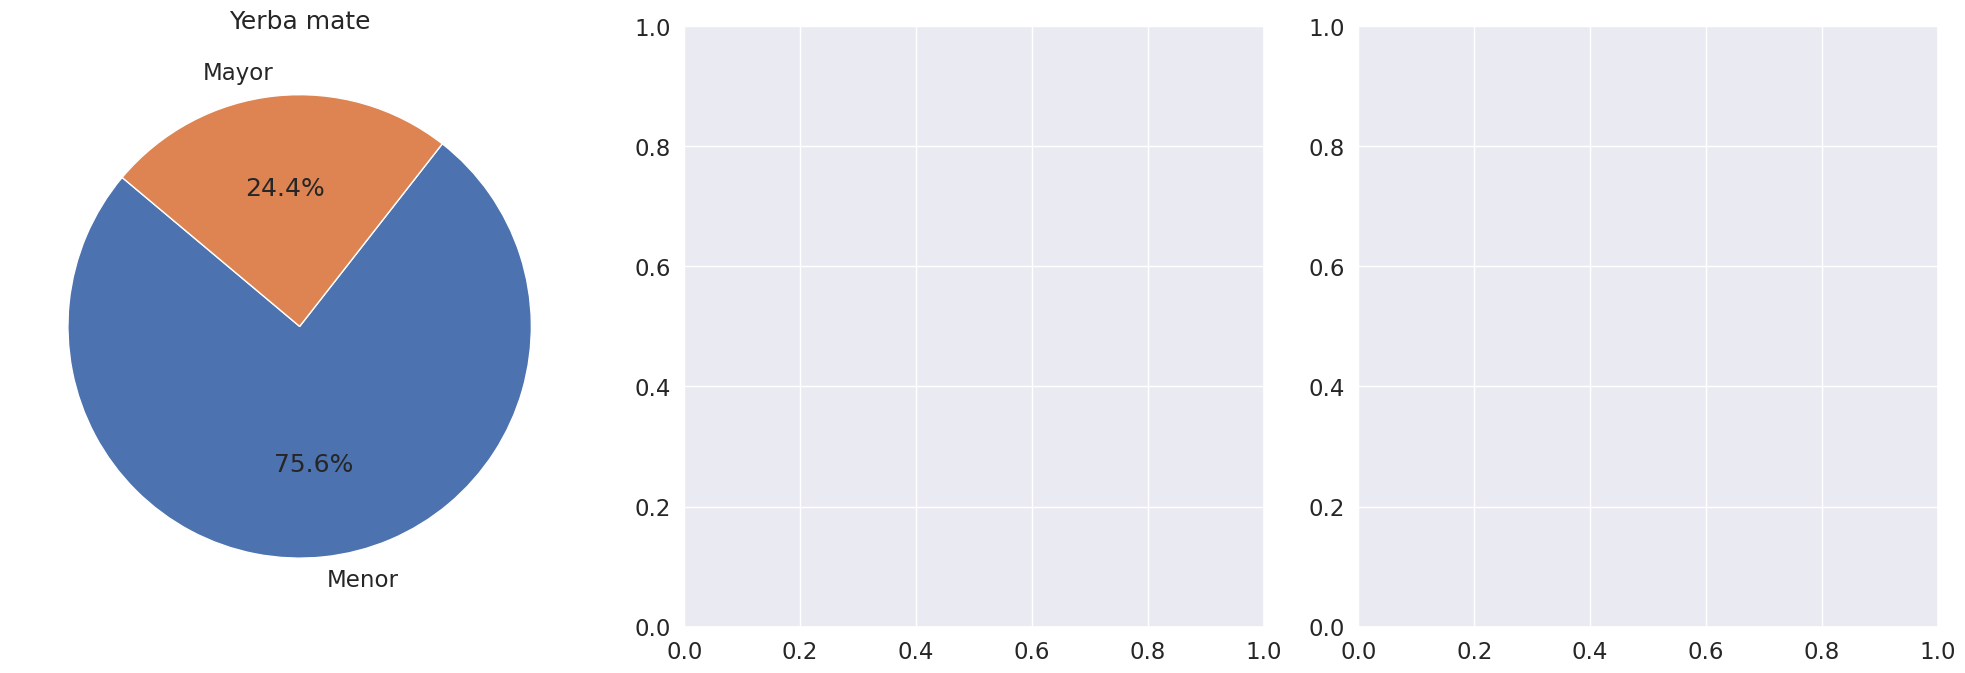

In [47]:
# Calcular la media de rendimiento para cada cultivo
media_produccion = df.groupby('cultivo')['produccion'].mean()

# Obtener la lista de cultivos
cultivos = media_produccion.index.tolist()

# Calcular la cantidad de figuras necesarias
num_figuras = (len(cultivos) + 2) // 3  # División redondeada hacia arriba

# Crear las figuras con subplots
for fig_idx in range(num_figuras):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
    
    # Iterar sobre cada subplot
    for idx, ax in enumerate(axes):
        cultivo_idx = fig_idx * 3 + idx
        if cultivo_idx < len(cultivos):
            cultivo = cultivos[cultivo_idx]
            # Filtrar los datos para el cultivo actual y calcular la clasificación
            produccion_cultivo = df[df['cultivo'] == cultivo]['produccion']
            media_cultivo = media_produccion[cultivo]
            rendimiento_clasificado = produccion_cultivo.apply(lambda x: 'Mayor' if x > media_cultivo else 'Menor')
            # Contar la frecuencia de cada clasificación
            conteo = rendimiento_clasificado.value_counts()
            # Crear el gráfico de torta
            ax.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=140)
            ax.set_title(cultivo)
    
    plt.tight_layout()
    plt.show()

## Produccion por provincia

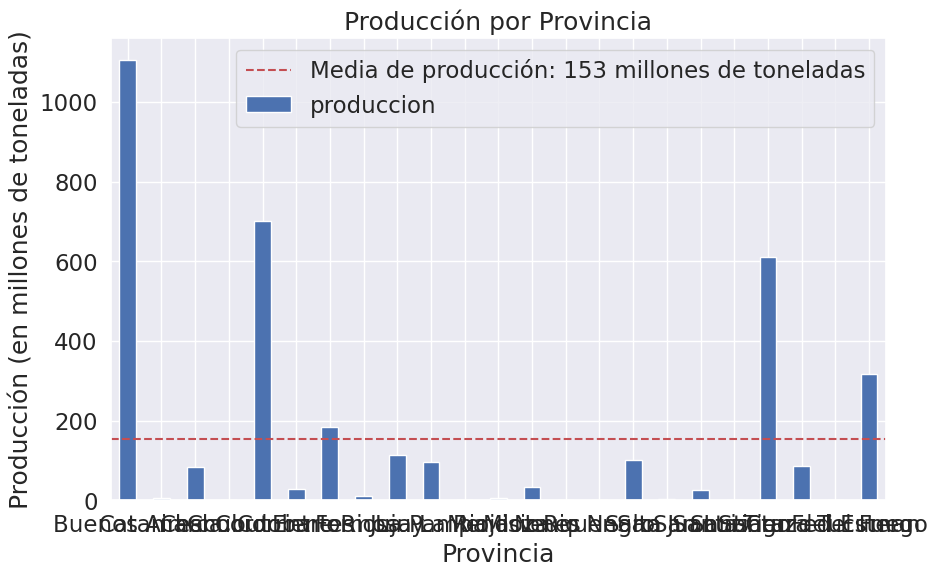

In [48]:
# Calcular la producción por provincia
produccion_por_provincia = df.groupby('provincia')['produccion'].sum() / 1e6

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
produccion_por_provincia.plot(kind='bar')

# Agregar la línea de la media de producción
mean_produccion = produccion_por_provincia.mean()
plt.axhline(mean_produccion, color='r', linestyle='--', label=f'Media de producción: {mean_produccion:.0f} millones de toneladas')
plt.title('Producción por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Producción (en millones de toneladas)')
plt.legend()
plt.xticks(rotation=360)
plt.show()

## Temperatura vs producción por cultivo

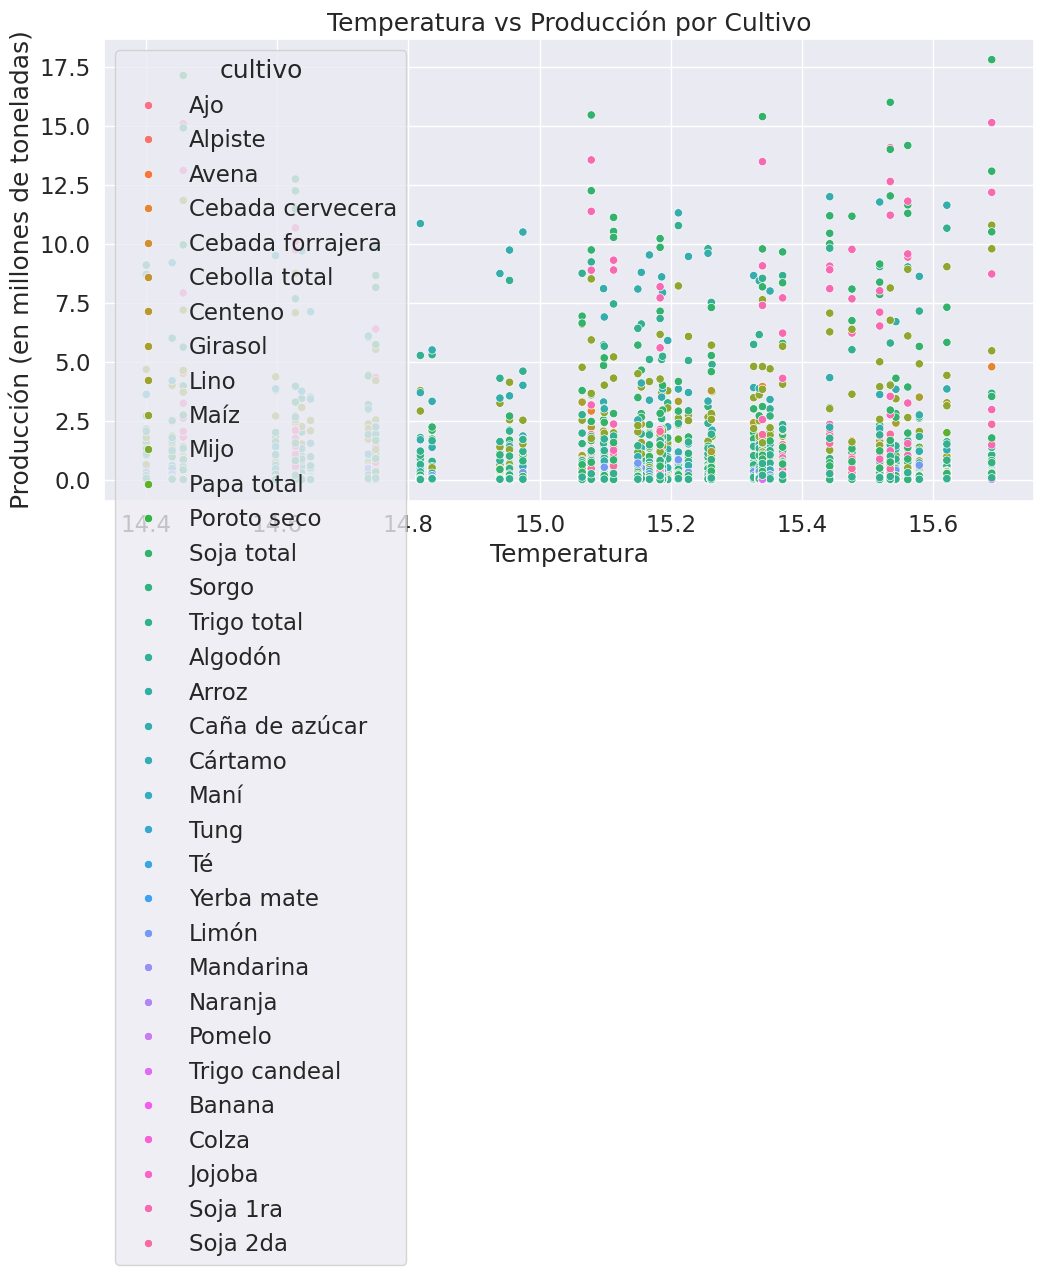

In [49]:
# Crear el scatter plot y dividir 'produccion' por 1e6 directamente en el gráfico
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temperatura', y=df['produccion'] / 1e6, hue='cultivo', data=df)
plt.title('Temperatura vs Producción por Cultivo')
plt.xlabel('Temperatura')
plt.ylabel('Producción (en millones de toneladas)')
plt.show()

## Superficie sembrada vs Superficie cosechada junto con la producción

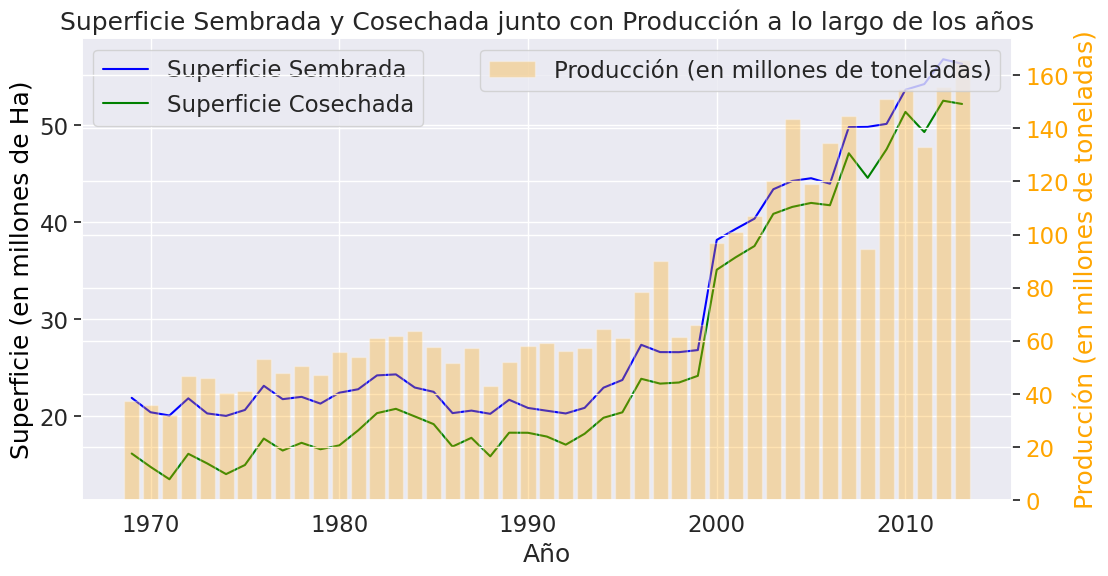

In [50]:
# Agrupar por año y calcular la suma de la superficie sembrada y cosechada
superficie_por_año = df.groupby('año_inicio')[['sup_sembrada', 'sup_cosechada']].sum()

# Calcular la producción total por año
produccion_por_año = df.groupby('año_inicio')['produccion'].sum()

# Crear la figura y el eje
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de líneas para la superficie sembrada y cosechada
ax1.plot(superficie_por_año.index, superficie_por_año['sup_sembrada'] / 1e6, label='Superficie Sembrada', color='blue')
ax1.plot(superficie_por_año.index, superficie_por_año['sup_cosechada'] / 1e6, label='Superficie Cosechada', color='green')
ax1.set_xlabel('Año')
ax1.set_ylabel('Superficie (en millones de Ha)', color='black')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Crear un segundo eje para el gráfico de barras
ax2 = ax1.twinx()
ax2.bar(produccion_por_año.index, produccion_por_año / 1e6, alpha=0.3, label='Producción (en millones de toneladas)', color='orange')
ax2.set_ylabel('Producción (en millones de toneladas)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Título del gráfico
plt.title('Superficie Sembrada y Cosechada junto con Producción a lo largo de los años')

# Mostrar el gráfico
plt.show()

## Cultivos con mayor producción

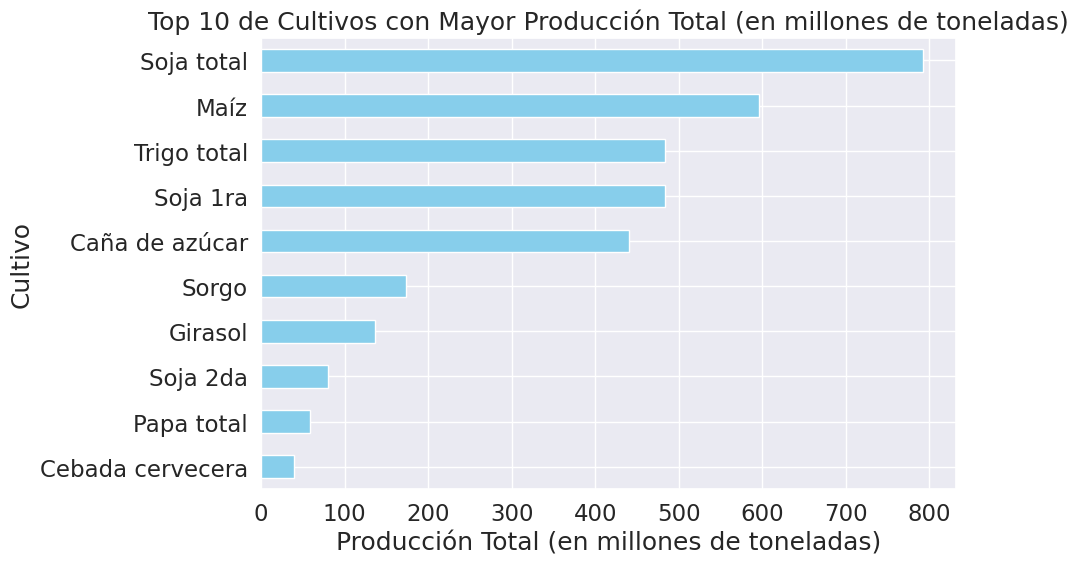

In [51]:
# Calcular la producción total por cultivo
produccion_total_por_cultivo = df.groupby('cultivo')['produccion'].sum() / 1e6  # Dividir por 1e6 para millones de toneladas

# Ordenar las producciones de mayor a menor y seleccionar los 10 primeros
top_10_produccion = produccion_total_por_cultivo.sort_values(ascending=False).head(10)

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
top_10_produccion.plot(kind='barh', color='skyblue')
plt.title('Top 10 de Cultivos con Mayor Producción Total (en millones de toneladas)')
plt.xlabel('Producción Total (en millones de toneladas)')
plt.ylabel('Cultivo')
plt.gca().invert_yaxis()  # Invertir el eje y para ordenar de mayor a menor
plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

# Analisis de datos

## Matriz de correlación

In [52]:
df_corr = df.copy()

In [53]:
# Selecciona solo las columnas numéricas
df_corr = df_corr.select_dtypes(include=[np.number])

# calcular la correlacion
correlation = df_corr.corr()

# mostrarme el mapa de calor
print(f'Matriz de Correlación para todos los cultivos')
correlation.style.background_gradient(cmap='coolwarm')

Matriz de Correlación para todos los cultivos


## Matriz de correlación por cultivos

In [54]:
df_corr_ajustada = df.copy()

In [55]:
df_corr_ajustada.dtypes

año_inicio         int64
año_fin            int64
provincia         object
cultivo           object
sup_sembrada       int64
sup_cosechada      int64
produccion         int64
rendimiento        int64
temperatura      float64
molisoles          int64
vertisoles         int64
entisoles          int64
aridisoles         int64
ultisoles          int64
inceptisoles       int64
histosoles         int64
dtype: object

In [56]:
### aca estoy evaluando distintas combinaciones de cultivos para ver si logro obtener buenas correlaciones
#top_cultivos = ['Soja total']
#top_cultivos = ['Maíz']
#top_cultivos = ['Trigo total']
#top_cultivos = ['Girasol']
#top_cultivos = ['Soja total', 'Girasol']
#top_cultivos = ['Soja total', 'Girasol', 'Trigo total']

# cuando incluyo maiz baja la correlacion de rendimiento
top_cultivos = ['Soja total', 'Maíz', 'Trigo total', 'Girasol']

# Filtra el DataFrame para incluir solo las filas que contienen estos cultivos 
df_corr_ajustada = df_corr_ajustada[df_corr_ajustada['cultivo'].isin(top_cultivos)]

In [57]:
# provincias argentinas de mayor a menor produccion agricola
top_provincias = [
    "Buenos Aires",
    "Cordoba",
    "Santa Fe",
    "Entre Rios",
    "La Pampa",
    "Chaco",
    "Santiago del Estero",
    "San Luis"
]

# Filtra el DataFrame para incluir solo las filas que contienen estas provincias
df_corr_ajustada = df_corr_ajustada[df_corr_ajustada['provincia'].isin(top_provincias)]

In [58]:
df_corr_ajustada.shape

(1395, 16)

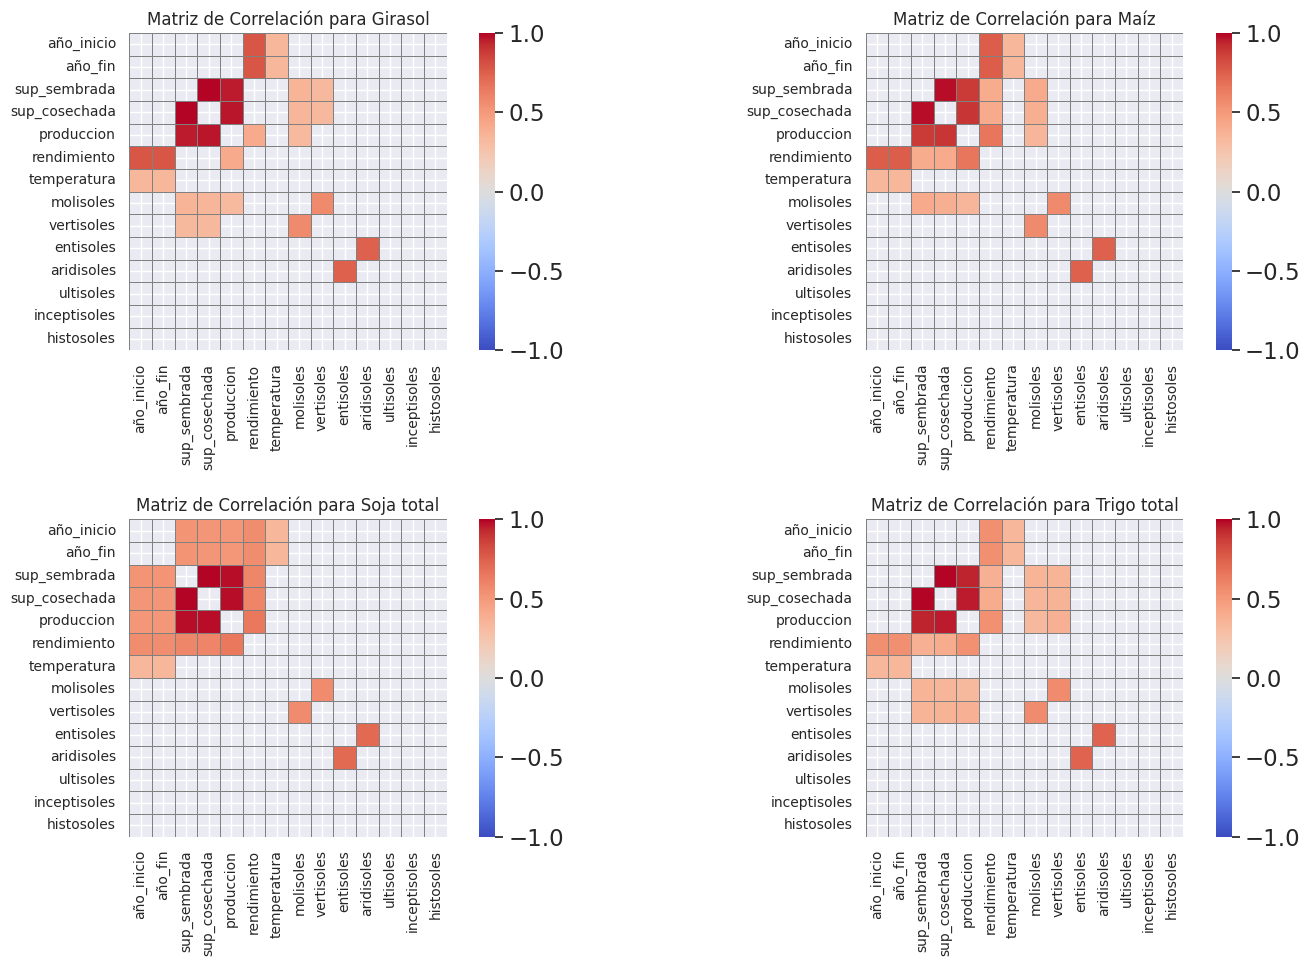

In [59]:
cultivos = df_corr_ajustada['cultivo'].unique()

# Configurar la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # Aplanar la matriz de ejes para un acceso más fácil

for i, cultivo in enumerate(cultivos):
    # Filtrar el DataFrame por cultivo
    df_cultivo = df_corr_ajustada[df_corr_ajustada['cultivo'] == cultivo].copy()
    
    # Calcular la matriz de correlación
    correlacion_por_cultivo = df_cultivo.select_dtypes(include=[np.number]).corr()
    
    # Filtrar las correlaciones mayores a 0.30
    mask = (correlacion_por_cultivo > 0.30) & (correlacion_por_cultivo < 1)
    correlacion_filtrada = correlacion_por_cultivo.where(mask)
    
    # Mostrar la matriz de correlación usando seaborn sin los números
    sns.heatmap(correlacion_filtrada, cmap='coolwarm', ax=axes[i], vmin=-1, vmax=1, cbar=True, annot=False, square=True, linewidths=0.5, linecolor='gray')
    axes[i].set_title(f'Matriz de Correlación para {cultivo}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=90, labelsize=10)
    axes[i].tick_params(axis='y', rotation=0, labelsize=10)
    axes[i].set_yticklabels(correlacion_filtrada.index, rotation=0, ha='right')  # Centrar etiquetas en cada fila
    
# Ajustar el layout de la figura
plt.tight_layout()
plt.show()

In [60]:
cultivos = df_corr_ajustada['cultivo'].unique()

for cultivo in cultivos:
    df_cultivo = df_corr_ajustada[df_corr_ajustada['cultivo'] == cultivo].copy()
    correlacion_por_cultivo = df_cultivo.select_dtypes(include=[np.number]).corr()
    
    # Mostrar la matriz de correlación usando pandas
    print(f'Matriz de Correlación para {cultivo}')
    display(correlacion_por_cultivo.style.background_gradient(cmap='coolwarm'))

Matriz de Correlación para Girasol


Matriz de Correlación para Maíz


Matriz de Correlación para Soja total


Matriz de Correlación para Trigo total


## Matriz de correlación ajustada

In [61]:
# quitar el año de inicio y fin de campaña que no tienen sentido
# por que motivo? 
# 1. no proporcionan informacion directa sobre el rendimiento o la produccion?
# 2. no son esenciales en el analisis?
# 3. sesga el modelo para datos futuros?
# 4. para simplificar el modelo?
# 5. valores independientes¿? la produccion del 2024 no influye en la de la campaña 2025

columnas_a_excluir = ['año_inicio', 'año_fin', 'entisoles', 'aridisoles', 'ultisoles', 'inceptisoles', 'histosoles']
df_corr_ajustada = df_corr_ajustada.drop(columns=columnas_a_excluir)

In [62]:
df_corr_ajustada.shape

(1395, 9)

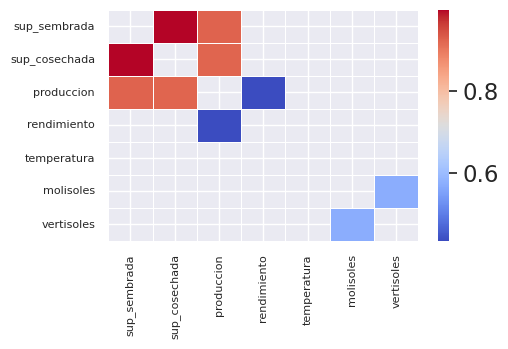

In [63]:
correlation_matrix = df_corr_ajustada.select_dtypes(include=[np.number]).corr()
    
# Filtrar las correlaciones mayores a 0.30
mask = (correlation_matrix > 0.30) & (correlation_matrix < 1)
correlation_matrix = correlation_matrix.where(mask)

# Plot
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5)
plt.yticks(rotation=0, fontsize=8)
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [64]:
# Selecciona solo las columnas numéricas y calcular la correlacion
correlation = df_corr_ajustada.select_dtypes(include=[np.number]).corr()

# mostrame el mapa de calor
print(f'Matriz de Correlación Ajustada por cultivos')
correlation.style.background_gradient(cmap='coolwarm')

Matriz de Correlación Ajustada por cultivos


## Primer objetivo

In [92]:
df_obj1 = df.copy()

In [93]:
df_obj1.shape

(9710, 16)

In [94]:
columnas_a_excluir = ['año_inicio', 'año_fin', 'entisoles', 'aridisoles', 'ultisoles', 'inceptisoles', 'histosoles']
df_obj1 = df_obj1.drop(columns=columnas_a_excluir)

In [95]:
#top_cultivos = ['Soja total', 'Girasol', 'Trigo total']

# cuando incluyo maiz baja la correlacion de rendimiento
top_cultivos = ['Soja total', 'Maíz', 'Trigo total', 'Girasol']

# Filtra el DataFrame para incluir solo las filas que contienen estos cultivos 
df_obj1 = df_obj1[df_obj1['cultivo'].isin(top_cultivos)]

In [96]:
valores_unicos = df_obj1['provincia'].unique()
print(valores_unicos)

['Buenos Aires' 'Catamarca' 'Chaco' 'Cordoba' 'Corrientes' 'Entre Rios'
 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja' 'Mendoza' 'Misiones' 'Neuquen'
 'Rio Negro' 'Salta' 'San Juan' 'San Luis' 'Santa Cruz' 'Santa Fe'
 'Santiago del Estero' 'Tucuman' 'Chubut']


In [97]:
# provincias argentinas de mayor a menor produccion agricola
top_provincias = [
    "Buenos Aires",
    "Cordoba",
    "Santa Fe",
    "Entre Rios",
    "La Pampa",
    "Chaco",
    "Santiago del Estero",
    "San Luis"
]

# Filtra el DataFrame para incluir solo las filas que contienen estas provincias
df_obj1 = df_obj1[df_obj1['provincia'].isin(top_provincias)]

In [98]:
# Selecciona solo las columnas numéricas y calcular la correlacion
correlation = df_obj1.select_dtypes(include=[np.number]).corr()

# mostrame el mapa de calor
print(f'Matriz de Correlación para el objetivo 1')
correlation.style.background_gradient(cmap='coolwarm')

Matriz de Correlación para el objetivo 1


In [99]:
# esto es para evitar el desbalanceo de clases de nuestras variables objetivo

# Calcular la media de rendimiento para cada cultivo
media_rendimiento = df_obj1.groupby('cultivo')['rendimiento'].transform('mean')

# Crear la columna nivel_rendimiento
df_obj1['nivel_rendimiento'] = np.where(df_obj1['rendimiento'] > media_rendimiento, 'mayor', 'menor')

In [100]:
df_obj1.shape

(1395, 10)

In [101]:
frecuencia_valores = df_obj1['nivel_rendimiento'].value_counts()
print(frecuencia_valores)

nivel_rendimiento
menor    765
mayor    630
Name: count, dtype: int64


In [102]:
df_obj1.describe()

sup_sembrada  sup_cosechada    produccion  rendimiento  temperatura  \
count  1.395000e+03   1.395000e+03  1.395000e+03  1395.000000  1395.000000   
mean   5.794300e+05   5.384766e+05  1.394642e+06  2041.157706    15.123155   
std    9.333093e+05   9.091058e+05  2.500604e+06  1310.676173     0.334309   
min    5.000000e+01   3.000000e+01  2.000000e+01   361.000000    14.400833   
25%    4.800000e+04   4.000000e+04  5.900000e+04  1250.500000    14.939667   
50%    2.243000e+05   1.788500e+05  3.140000e+05  1701.000000    15.183750   
75%    7.117750e+05   6.453500e+05  1.570140e+06  2341.500000    15.339667   
max    6.734155e+06   6.625050e+06  1.781297e+07  8574.000000    15.689000   

         molisoles   vertisoles  
count  1395.000000  1395.000000  
mean      0.762007     0.512545  
std       0.426007     0.500022  
min       0.000000     0.000000  
25%       1.000000     0.000000  
50%       1.000000     1.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000

In [103]:
# Variables de interés
var_caract_obj1 = [
    'provincia',
    'cultivo',
    
    'sup_sembrada',
    'sup_cosechada',
    
    'temperatura',
    
    'molisoles', 
    'vertisoles',

    #'entisoles', 'aridisoles', 
    #'ultisoles', 'inceptisoles', 'histosoles'
]

# Selección de características y variable objetivo
X = df_obj1[var_caract_obj1]
y = df_obj1['nivel_rendimiento']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento antes de entrenar el modelo
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), [
            'provincia', 
            'cultivo'
        ]),
        ('num', StandardScaler(), [
            'sup_sembrada', 
            'sup_cosechada', 
            'temperatura'
        ])
    ])

# Crear el pipeline con el preprocesador y el clasificador MLP
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, solver='adam', activation='relu', random_state=42))
])

# Entrenar el modelo
clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted')

# Mostrar métricas de evaluación
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 0.75
Precision: 0.75
F1-score: 0.75


Matriz de Confusión:
[[ 81  34]
 [ 37 127]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       mayor       0.69      0.70      0.70       115
       menor       0.79      0.77      0.78       164

    accuracy                           0.75       279
   macro avg       0.74      0.74      0.74       279
weighted avg       0.75      0.75      0.75       279



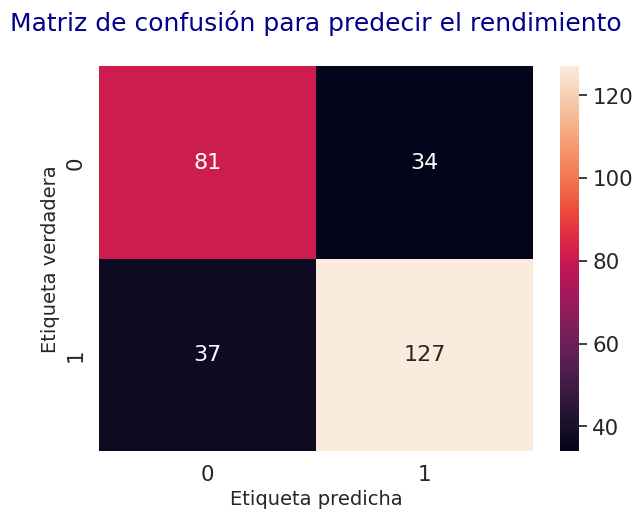

In [104]:
cm = confusion_matrix(y_test, y_pred)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

# También puedes imprimir un reporte de clasificación
report = classification_report(y_test, y_pred)
print("\nReporte de Clasificación:")
print(report)

# Ajustar el tamaño de la figura
plt.figure(figsize=(7, 5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16, "ha": 'center', "va": 'center'}, fmt='d')

plt.title('Matriz de confusión para predecir el rendimiento\n', fontsize = 18, color = 'darkblue')
plt.ylabel('Etiqueta verdadera', fontsize = 14)
plt.xlabel('Etiqueta predicha', fontsize = 14)
plt.show()

In [105]:
datos_prueba = {   
    'provincia': ['Buenos Aires'],
    'cultivo': ['Soja total'],
    
    'sup_sembrada': [900000], 
    'sup_cosechada': [900000],

    'temperatura': [18],
    
    'molisoles': [1], 
    'vertisoles': [1],
    #'entisoles', 'aridisoles', 
    #'ultisoles', 'inceptisoles', 'histosoles'
}

# Convertir a DataFrame
prueba = pd.DataFrame(datos_prueba)

# Realizar la predicción utilizando el pipeline que ya incluye el preprocesamiento
prediccion_rendimiento = clf.predict(prueba)

print(f'Predicción de producción: {prediccion_rendimiento[0]}')

Predicción de producción: mayor


## Segundo objetivo

In [106]:
df_obj2 = df.copy()

In [107]:
df_obj2.shape

(9710, 16)

In [108]:
columnas_a_excluir = ['año_inicio', 'año_fin']
df_obj2 = df_obj2.drop(columns=columnas_a_excluir)

In [109]:
#top_cultivos = ['Soja total', 'Girasol', 'Trigo total']

# cuando incluyo maiz baja la correlacion de rendimiento
top_cultivos = ['Soja total', 'Maíz', 'Trigo total', 'Girasol']

# Filtra el DataFrame para incluir solo las filas que contienen estos cultivos 
df_obj2 = df_obj2[df_obj2['cultivo'].isin(top_cultivos)]

In [110]:
valores_unicos = df_obj2['provincia'].unique()
print(valores_unicos)

['Buenos Aires' 'Catamarca' 'Chaco' 'Cordoba' 'Corrientes' 'Entre Rios'
 'Formosa' 'Jujuy' 'La Pampa' 'La Rioja' 'Mendoza' 'Misiones' 'Neuquen'
 'Rio Negro' 'Salta' 'San Juan' 'San Luis' 'Santa Cruz' 'Santa Fe'
 'Santiago del Estero' 'Tucuman' 'Chubut']


In [111]:
# provincias argentinas de mayor a menor produccion agricola
top_provincias = [
    "Buenos Aires",
    "Cordoba",
    "Santa Fe",
    "Entre Rios",
    "La Pampa",
    "Chaco",
    "Santiago del Estero",
    "San Luis"
]

# Filtra el DataFrame para incluir solo las filas que contienen estas provincias
df_obj2 = df_obj2[df_obj2['provincia'].isin(top_provincias)]

In [112]:
# Selecciona solo las columnas numéricas y calcular la correlacion
correlation = df_obj2.select_dtypes(include=[np.number]).corr()

# mostrame el mapa de calor
print(f'Matriz de Correlación para el objetivo 2')
correlation.style.background_gradient(cmap='coolwarm')

Matriz de Correlación para el objetivo 2


In [113]:
# esto es para evitar el desbalanceo de clases de nuestras variables objetivo

# Calcular la media de rendimiento para cada cultivo
media_produccion = df_obj2.groupby('cultivo')['produccion'].transform('mean')

# Crear la columna nivel_rendimiento
df_obj2['nivel_produccion'] = np.where(df_obj2['produccion'] > media_produccion, 'mayor', 'menor')

In [114]:
frecuencia_valores = df_obj2['nivel_produccion'].value_counts()
print(frecuencia_valores)

nivel_produccion
menor    985
mayor    410
Name: count, dtype: int64


In [115]:
df_obj2.describe()

sup_sembrada  sup_cosechada    produccion  rendimiento  temperatura  \
count  1.395000e+03   1.395000e+03  1.395000e+03  1395.000000  1395.000000   
mean   5.794300e+05   5.384766e+05  1.394642e+06  2041.157706    15.123155   
std    9.333093e+05   9.091058e+05  2.500604e+06  1310.676173     0.334309   
min    5.000000e+01   3.000000e+01  2.000000e+01   361.000000    14.400833   
25%    4.800000e+04   4.000000e+04  5.900000e+04  1250.500000    14.939667   
50%    2.243000e+05   1.788500e+05  3.140000e+05  1701.000000    15.183750   
75%    7.117750e+05   6.453500e+05  1.570140e+06  2341.500000    15.339667   
max    6.734155e+06   6.625050e+06  1.781297e+07  8574.000000    15.689000   

         molisoles   vertisoles    entisoles   aridisoles  ultisoles  \
count  1395.000000  1395.000000  1395.000000  1395.000000     1395.0   
mean      0.762007     0.512545     0.365591     0.237993        0.0   
std       0.426007     0.500022     0.481768     0.426007        0.0   
min       0.000000     0.000000     0.000000     0.000000        0.0   
25%       1.000000     0.000000     0.000000     0.000000        0.0   
50%       1.000000     1.000000     0.000000     0.000000        0.0   
75%       1.000000     1.000000     1.000000     0.000000        0.0   
max       1.000000     1.000000     1.000000     1.000000        0.0   

       inceptisoles  histosoles  
count        1395.0      1395.0  
mean            0.0         0.0  
std             0.0         0.0  
min             0.0         0.0  
25%             0.0         0.0  
50%             0.0         0.0  
75%             0.0         0.0  
max             0.0         0.0

In [116]:
# Variables de interés
var_caract_obj2 = [
    'provincia',
    'cultivo', 
    
    'sup_sembrada',
    'sup_cosechada',
    
    'temperatura',
    
    'molisoles', 
    'vertisoles',

    #'entisoles', 'aridisoles', 
    #'ultisoles', 'inceptisoles', 'histosoles'
]

# Selección de características y variable objetivo
X = df_obj2[var_caract_obj2]
y = df_obj2['nivel_produccion']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento antes de entrenar el modelo
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['provincia', 'cultivo']),
        ('num', StandardScaler(), ['sup_sembrada', 'sup_cosechada', 'temperatura'])
    ])

# Crear el pipeline con el preprocesador y el clasificador MLP
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, solver='sgd', activation='tanh', random_state=42))
])

# Entrenar el modelo
clf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted')

# Mostrar métricas de evaluación
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 0.95
Precision: 0.95
F1-score: 0.95


Matriz de Confusión:
[[ 66  11]
 [  4 198]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       mayor       0.94      0.86      0.90        77
       menor       0.95      0.98      0.96       202

    accuracy                           0.95       279
   macro avg       0.95      0.92      0.93       279
weighted avg       0.95      0.95      0.95       279



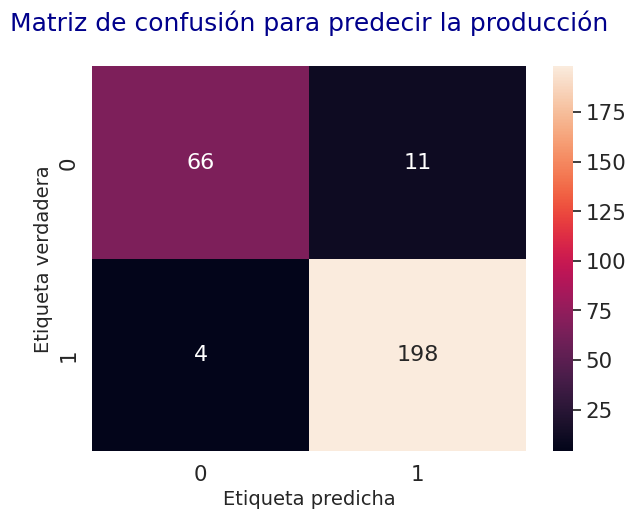

In [117]:
cm = confusion_matrix(y_test, y_pred)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

# También puedes imprimir un reporte de clasificación
report = classification_report(y_test, y_pred)
print("\nReporte de Clasificación:")
print(report)

# Ajustar el tamaño de la figura
plt.figure(figsize=(7, 5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16, "ha": 'center', "va": 'center'}, fmt='d')

plt.title('Matriz de confusión para predecir la producción\n', fontsize = 18, color = 'darkblue')
plt.ylabel('Etiqueta verdadera', fontsize = 14)
plt.xlabel('Etiqueta predicha', fontsize = 14)
plt.show()

In [118]:
datos_prueba = {
    'provincia': 'Buenos Aires',
    'cultivo': ['Soja total'],
    
    'sup_sembrada': [900000],
    'sup_cosechada': [900000],
    
    'temperatura': [18],
    
    'molisoles': [1], 
    'vertisoles': [1],
    
    #'entisoles', 'aridisoles', 
    #'ultisoles', 'inceptisoles', 'histosoles'
}

# Convertir a DataFrame
prueba = pd.DataFrame(datos_prueba)

# Realizar la predicción utilizando el pipeline que ya incluye el preprocesamiento
prediccion_produccion = clf.predict(prueba)

print(f'Predicción de producción: {prediccion_produccion[0]}')

Predicción de producción: mayor
